### Emulating a MIMO MPC with an LSTM Network

This is a 3rd case study on automating a temperature control process with an LSTM network with two prior case studies on PID control and SISO (Single Input, Single Output) MPC. In this case study, the LSTM network is trained from a 2x2 MIMO MPC (Single Input Single Output, Model Predictive Control). LSTM (Long Short Term Memory) networks are a special type of RNN (Recurrent Neural Network) that is structured to remember and predict based on long-term dependencies that are trained with time-series data.

<img align=left width=400px src='https://apmonitor.com/do/uploads/Main/lstm_mpc_2x2.png'>

The LSTM is trained (parameters adjusted) with an input window of prior data and minimized difference between the predicted and next measured value. Sequential methods predict just one next value based on the window of prior data. In this case, the difference between the set points ($T_{SP,1}$ and $T_{SP,2}$) and measured values ($T_{1}$ and $T_{2}$) are the features and the heater values ($Q_1$ and $Q_2$) are the output labels.

See [LSTM Networks](https://apmonitor.com/do/index.php/Main/LSTMNetwork) and [Automation with LSTM Networks (PID and SISO MPC)](https://apmonitor.com/pds/index.php/Main/LSTMAutomation) for additional details.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

# For Gekko and TCLab
import tclab
from gekko import GEKKO

2022-02-28 11:28:25.226988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/curtis/curtis_ws/devel/lib:/opt/ros/noetic/lib
2022-02-28 11:28:25.227007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Use [TCLab](https://apmonitor.com/heat.htm) Microcontroller or Emulator (Digital Twin)

Change `tclab_hardware` to `True` if TCLab device is connected.

<img width=550px align=left src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

In [5]:
tclab_hardware = True # True (if hardware is available)
if tclab_hardware:
    mlab = tclab.TCLab      # Physical hardware
else:
    speedup = 100
    mlab = tclab.setup(connected=False, speedup = speedup) # Emulator

### PID control and SISO MPC 

See [LSTM Network Replaces PID and SISO MPC](https://github.com/APMonitor/pds/blob/main/LSTM_Automation.ipynb) for code with a PID controller or Single Input, Single Output (1x1) Model Predictive Control (MPC) instead of this 2x2 MPC.

### MPC (Model Predictive Control)

See the last example for [MPC with TCLab](https://apmonitor.com/pds/notebooks/12_time_series.html) or the [Linear MPC with TCLab](https://apmonitor.com/do/index.php/Main/TCLabF). The steps to create an MPC application are:

- generate step test data
- identify model
- initialize controller
- create MPC function to return Q1

**Generate Step Test Data**

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Time: 0 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 2 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 4 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 6 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 8 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 10 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 12 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 14 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 16 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 18 Q1: 0.0 Q2: 0.0 T1: 22.83 T2: 22.19
Time: 20 Q1: 80.0 Q2: 0.0 T1: 20.54 T2: 22.12
Time: 22 Q1: 80.0 Q2: 0.0 T1: 22.83 T2: 22.12
Time: 24 Q1: 80.0 Q2: 0.0 T1: 22.8 T2: 21.9
Time: 26 Q1: 80.0 Q2: 0.0 T1: 23.02 T2: 22.16
Time: 28 Q1: 80.0 Q2: 0.0 T1: 23.28 T2: 22.61
Time: 30 Q1: 80.0 Q2: 0.0 T1: 23.64 T2: 22.16
Time: 32 Q1: 80.0 Q2: 0.0 T1: 23.77 T2: 22.16
Time: 34 Q1: 80.0 Q2: 0.0 T1: 24.09 T2: 22.16
Time: 36 Q1: 80.0 Q2: 0.0 T1: 24.44 T2: 22.16
Time: 38 Q1: 8

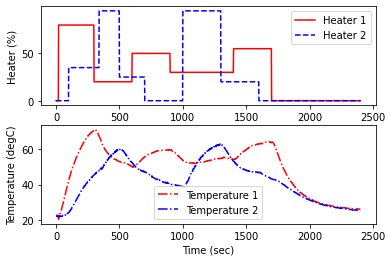

In [6]:
# generate step test data on TCLab
filename = 'tclab_data.csv'

n = 1200
tm = np.linspace(0,n*2,n+1)
T1 = np.zeros(n+1)
T2 = np.zeros(n+1)

# heater steps
Q1d = np.zeros(n+1)
Q1d[10:150]=80;  Q1d[150:300]=20; Q1d[300:450]=70; Q1d[300:450]=50
Q1d[450:700]=30; Q1d[700:850]=55; Q1d[850:]=0

Q2d = np.zeros(n+1)
Q2d[50:170]=35;  Q2d[170:250]=95; Q2d[250:350]=25; Q2d[350:500]=0
Q2d[500:650]=95; Q2d[650:800]=20; Q2d[800:]=0

p1 = 1 if tclab_hardware else 100
# Connect to TCLab
with mlab() as lab:
    # run step test
    i = 0
    for t in tclab.clock(tm[-1]+1, 2):
        # set heater values
        lab.Q1(Q1d[i])
        lab.Q2(Q2d[i])
        T1[i] = lab.T1
        T2[i] = lab.T2
        if i%p1==0:
            print('Time: ' + str(2*i) + \
              ' Q1: ' + str(Q1d[i]) + \
              ' Q2: ' + str(Q2d[i]) + \
              ' T1: ' + str(round(T1[i],2)) + \
              ' T2: ' + str(round(T2[i],2)))            
        i+=1

# write data to file
fid = open(filename,'w')
fid.write('Time,Q1,Q2,T1,T2\n')
for i in range(n+1):
    fid.write(str(tm[i])+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(T1[i])+','+str(T2[i])+'\n')
fid.close()
                
# read data file
data = pd.read_csv(filename)

# plot measurements
plt.figure()
plt.subplot(2,1,1)
plt.plot(data['Time'],data['Q1'],'r-',label='Heater 1')
plt.plot(data['Time'],data['Q2'],'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r-.',label='Temperature 1')
plt.plot(data['Time'],data['T2'],'b-.',label='Temperature 2')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('tclab_data.png')
plt.show()

**Identify Model**

Identify model


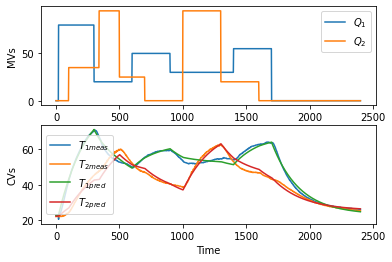

In [7]:
#########################################################
# Initialize Model
#########################################################
# load data and parse into columns
data = pd.read_csv('tclab_data.csv')
t = data['Time']
u = data[['Q1','Q2']]
y = data[['T1','T2']]

# generate time-series model
m = GEKKO(remote=False)

##################################################################
# system identification
na=2; nb=2 # ARX coefficients
print('Identify model')
yp,p,K = m.sysid(t,u,y,na,nb,objf=100,scale=False,diaglevel=0,pred='meas')

##################################################################
# plot sysid results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$Q_1$',r'$Q_2$'])
plt.ylabel('MVs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$T_{1meas}$',r'$T_{2meas}$',\
            r'$T_{1pred}$',r'$T_{2pred}$'])
plt.ylabel('CVs')
plt.xlabel('Time')
plt.savefig('sysid.png')
plt.show()

**Initialize Controller**

Create 2x2 (2 Heaters, 2 Temperature Sensors) MPC and use all available Manipulated Variables (MVs) and Controlled Variables (CVs) for this application with a 2x2 MPC (MVs: `Q1` and `Q2`, CVs: `T1` and `T2`).

In [8]:
##################################################################
# create control ARX model
m = GEKKO(remote=False)
m.y = m.Array(m.CV,2)
m.u = m.Array(m.MV,2)
m.arx(p,m.y,m.u)

# rename CVs
m.TC1 = m.y[0]
m.TC2 = m.y[1]

# rename MVs
m.Q1 = m.u[0]
m.Q2 = m.u[1]

# steady state initialization
m.options.IMODE = 1
m.solve(disp=False)

# set up MPC
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 1 # APOPT
m.options.MV_STEP_HOR = 1
m.time=np.linspace(0,60,31)

# Manipulated variables
m.Q1.STATUS = 1  # manipulated
m.Q1.FSTATUS = 0 # not measured
m.Q1.DMAX = 100.0
m.Q1.DCOST = 5
m.Q1.UPPER = 100.0
m.Q1.LOWER = 0.0

m.Q2.STATUS = 1  # manipulated
m.Q2.FSTATUS = 0 # not measured
m.Q2.DMAX = 100.0
m.Q2.DCOST = 5
m.Q2.UPPER = 100.0
m.Q2.LOWER = 0.0
m.Q2.MEAS = 0    # set Q2=0

# Controlled variables
m.TC1.STATUS = 1     # drive to set point
m.TC1.FSTATUS = 1    # receive measurement
m.TC1.TAU = 20        # response speed (time constant)
m.TC1.TR_INIT = 2    # reference trajectory
m.TC1.TR_OPEN = 100  # for CV_TYPE=1
m.TC1.WSPHI = 10
m.TC1.WSPLO = 10
m.TC1.WSP = 10

m.TC2.STATUS = 1     # drive to set point
m.TC2.FSTATUS = 1    # receive measurement
m.TC2.TAU = 20        # response speed (time constant)
m.TC2.TR_INIT = 2    # dead-band
m.TC2.TR_OPEN = 100  # for CV_TYPE=1
m.TC2.WSPHI = 10
m.TC2.WSPLO = 10
m.TC2.WSP = 10

In [9]:
def mpc(m,T1,T1sp,T2,T2sp):    
    # Insert measurements
    m.TC1.MEAS = T1
    m.TC2.MEAS = T2

    # Adjust setpoints
    db1 = 0.1 # dead-band
    m.TC1.SP   = T1sp
    m.TC1.SPHI = T1sp + db1
    m.TC1.SPLO = T1sp - db1

    db2 = 0.1
    m.TC2.SP   = T2sp
    m.TC2.SPHI = T2sp + db2
    m.TC2.SPLO = T2sp - db2
    
    # Adjust heaters with MPC
    m.solve(disp=False) 

    if m.options.APPSTATUS == 1:
        # Retrieve new values
        Q1  = m.Q1.NEWVAL
        Q2  = m.Q2.NEWVAL
    else:
        # Solution failed
        Q1  = 0.0
        Q2  = 0.0    
    return [Q1,Q2]

### Generate data for training LSTM

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
TCLab disconnected successfully.


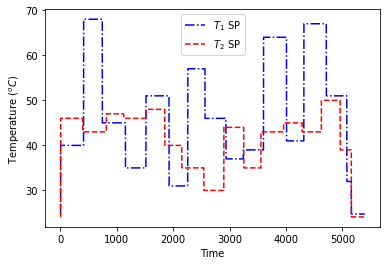

In [10]:
##### Set up run parameters #####
run_time = 90.0 # minutes

loops = int(30.0*run_time+1) # cycles (2 sec each)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
T2 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
Q2 = np.zeros(loops) # Heater values
tm = np.linspace(0,2*(loops-1),loops) # Time

# Temperature set point (degC)
with mlab() as lab:
    Tsp1 = np.ones(loops) * lab.T1
    Tsp2 = np.ones(loops) * lab.T2

# vary temperature setpoint
end = 2 # leave first couple cycles of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 5 to 7 min
    end += random.randint(150,210) 
    Tsp1[start:end] = random.randint(30,70)
Tsp1[-120:] = Tsp1[0] # last 4 minutes at room temperature

# vary temperature setpoint
end = 2 # leave first couple cycles of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 5 to 7 min
    end += random.randint(150,210) 
    Tsp2[start:end] = random.randint(30,50)
Tsp2[-120:] = Tsp2[0] # last 4 minutes at room temperature
    
if tclab_hardware:
    # print every cycle with hardware
    p1 = 10; p2 = 1
else:
    # print 20x less with emulator
    p1 = 200; p2 = 20   

# Plot
plt.plot(tm,Tsp1,'b-.',label=r'$T_1$ SP')
plt.plot(tm,Tsp2,'r--',label=r'$T_2$ SP')
plt.xlabel('Time')
plt.ylabel(r'Temperature ($^oC$)')
plt.legend()
plt.savefig('SP_profile.png');

### Data Collection

In [11]:
# MPC Data for LSTM Training
with mlab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    i = 0
    for t in tclab.clock(tm[-1]+1, 2):        
        # Read temperatures in Celcius 
        T1[i] = lab.T1; T2[i] = lab.T2

        # Calculate MPC output every 2 sec
        try:
            [Q1[i],Q2[i]] = mpc(m,T1[i],Tsp1[i],T2[i],Tsp2[i])
        except:
            Q1[i] = 0; Q2[i] = 0 # catch any failure to converge
        # Write heater output (0-100)
        lab.Q1(Q1[i])
        lab.Q2(Q2[i])
         
        if i%p1==0:            
            print('  Time_____Q1___Tsp1_____T1______Q2____Tsp2_____T2')
        if i%p2==0:
            print(('{:6.1f} {:6.2f} {:6.2f} {:6.2f}  {:6.2f}  {:6.2f} {:6.2f}').format( \
                      tm[i],Q1[i],Tsp1[i],T1[i],Q2[i],Tsp2[i],T2[i]))
        i+=1

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Temperature 1: 24.77 °C
Temperature 2: 24.12 °C
  Time_____Q1___Tsp1_____T1______Q2____Tsp2_____T2
   0.0   0.00  24.77  24.77    0.00   24.12  24.12
   2.0   0.00  24.77  24.77    0.00   24.12  24.12
   4.0  18.24  40.00  24.77   20.96   46.00  24.12
   6.0  33.27  40.00  24.77   38.94   46.00  24.12
   8.0  45.71  40.00  24.77   54.10   46.00  24.25
  10.0  56.03  40.00  24.80   66.78   46.00  24.25
  12.0  64.45  40.00  24.96   77.11   46.00  24.44
  14.0  71.39  40.00  25.09   85.37   46.00  24.41
  16.0  77.21  40.00  25.12   91.67   46.00  24.54
  18.0  81.87  40.00  25.38   96.14   46.00  24.73
  Time_____Q1___Tsp1_____T1______Q2____Tsp2_____T2
  20.0  85.56  40.00  25.70   98.90   46.00  24.60
  22.0  88.38  40.00  26.05  100.00   46.00  24.80
  24.0  90.45  40.00  26.38  100.00   46.00  25.25
  26.0  91.93  40.00  26.70  100.00   46.00  25.57
  28.0 

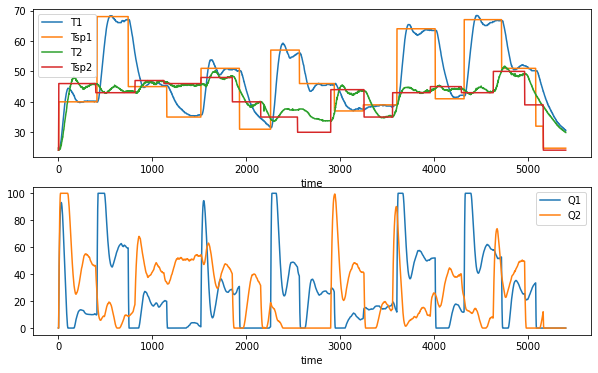

In [12]:
# Save csv file
df = pd.DataFrame()
df['time'] = tm[:i]
df['Q1'] = Q1[:i]; df['Q2'] = Q2[:i]
df['T1'] = T1[:i]; df['T2'] = T2[:i]
df['Tsp1'] = Tsp1[:i]; df['Tsp2'] = Tsp2[:i]
df.set_index('time',inplace=True)
df.to_csv('MPC_train_data.csv',index=False)

# Plot
plt.figure(figsize=(10,6))
plt.subplot(2,1,1); ax = plt.gca()
df[['T1','Tsp1','T2','Tsp2']].plot(ax=ax)
plt.subplot(2,1,2); ax = plt.gca()
df[['Q1','Q2']].plot(ax=ax)
plt.savefig('MPC_train.png');

### Feature engineering: create SP error feature and analyze feature importance

In [13]:
# Create new features: setpoint errors
df['err1'] = df['Tsp1'] - df['T1']
df['err2'] = df['Tsp2'] - df['T2']

### Feature Importance for Predicting Q1

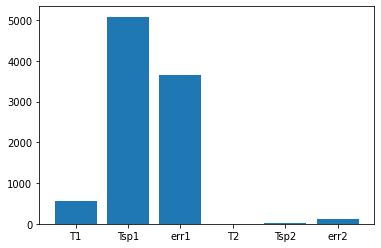

In [14]:
# Load possible features
X = df[['T1','Tsp1','err1','T2','Tsp2','err2']]
y = np.ravel(df[['Q1']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

### Feature Importance for Predicting Q2

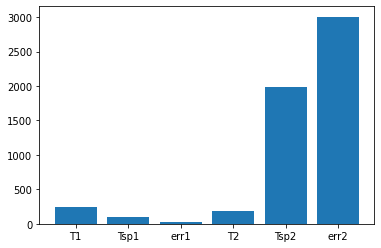

In [15]:
# Load possible features
X = df[['T1','Tsp1','err1','T2','Tsp2','err2']]
y = np.ravel(df[['Q2']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

### Feature selection, scaling, and formatting data to LSTM input format

In [16]:
X = df[['Tsp1','err1','Tsp2','err2']].values
y = df[['Q1','Q2']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
window = 15
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

### Keras LSTM 

2022-02-28 16:07:59.911343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 16:07:59.911695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/curtis/curtis_ws/devel/lib:/opt/ros/noetic/lib
2022-02-28 16:07:59.911753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/curtis/curtis_ws/devel/lib:/opt/ros/noetic/lib
2022-02-28 16:07:59.911795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot ope

Epoch 1/300


 4/18 [=====>........................] - ETA: 0s - loss: 0.0795 

11/18 [=================>............] - ETA: 0s - loss: 0.0606

15/18 [========================>.....] - ETA: 0s - loss: 0.0525

  0%|          | 1/300 [00:02<11:02,  2.21s/epoch, loss=0.0489, val_loss=0.0234]

18/18 [==============================] - 2s 39ms/step - loss: 0.0489 - val_loss: 0.0234


Epoch 2/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0287

12/18 [===================>..........] - ETA: 0s - loss: 0.0235

16/18 [=========================>....] - ETA: 0s - loss: 0.0228

  1%|          | 2/300 [00:02<05:27,  1.10s/epoch, loss=0.0227, val_loss=0.0191]

18/18 [==============================] - 0s 18ms/step - loss: 0.0227 - val_loss: 0.0191


Epoch 3/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0176

13/18 [====================>.........] - ETA: 0s - loss: 0.0165

17/18 [===========================>..] - ETA: 0s - loss: 0.0158

  1%|          | 3/300 [00:02<03:39,  1.35epoch/s, loss=0.0158, val_loss=0.0141]

18/18 [==============================] - 0s 17ms/step - loss: 0.0158 - val_loss: 0.0141


Epoch 4/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0130

13/18 [====================>.........] - ETA: 0s - loss: 0.0118

17/18 [===========================>..] - ETA: 0s - loss: 0.0113

  1%|▏         | 4/300 [00:03<02:50,  1.74epoch/s, loss=0.0114, val_loss=0.011] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0110


Epoch 5/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0090

13/18 [====================>.........] - ETA: 0s - loss: 0.0099

17/18 [===========================>..] - ETA: 0s - loss: 0.0095

  2%|▏         | 5/300 [00:03<02:22,  2.07epoch/s, loss=0.00953, val_loss=0.0108]

18/18 [==============================] - 0s 18ms/step - loss: 0.0095 - val_loss: 0.0108


Epoch 6/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0101

13/18 [====================>.........] - ETA: 0s - loss: 0.0093

17/18 [===========================>..] - ETA: 0s - loss: 0.0098

  2%|▏         | 6/300 [00:03<02:05,  2.35epoch/s, loss=0.00983, val_loss=0.0115]

18/18 [==============================] - 0s 17ms/step - loss: 0.0098 - val_loss: 0.0115


Epoch 7/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0105

13/18 [====================>.........] - ETA: 0s - loss: 0.0101

17/18 [===========================>..] - ETA: 0s - loss: 0.0098

  2%|▏         | 7/300 [00:04<01:54,  2.56epoch/s, loss=0.00976, val_loss=0.00806]

18/18 [==============================] - 0s 18ms/step - loss: 0.0098 - val_loss: 0.0081


Epoch 8/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0085

12/18 [===================>..........] - ETA: 0s - loss: 0.0085

16/18 [=========================>....] - ETA: 0s - loss: 0.0081

  3%|▎         | 8/300 [00:04<01:46,  2.73epoch/s, loss=0.00798, val_loss=0.00996]

18/18 [==============================] - 0s 17ms/step - loss: 0.0080 - val_loss: 0.0100


Epoch 9/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0090

13/18 [====================>.........] - ETA: 0s - loss: 0.0081

17/18 [===========================>..] - ETA: 0s - loss: 0.0079

  3%|▎         | 9/300 [00:04<01:42,  2.85epoch/s, loss=0.00788, val_loss=0.00821]

18/18 [==============================] - 0s 18ms/step - loss: 0.0079 - val_loss: 0.0082


Epoch 10/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0071

13/18 [====================>.........] - ETA: 0s - loss: 0.0069

17/18 [===========================>..] - ETA: 0s - loss: 0.0068

  3%|▎         | 10/300 [00:05<01:38,  2.95epoch/s, loss=0.00682, val_loss=0.00836]

18/18 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0084


Epoch 11/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0068

13/18 [====================>.........] - ETA: 0s - loss: 0.0068

17/18 [===========================>..] - ETA: 0s - loss: 0.0067

  4%|▎         | 11/300 [00:05<01:35,  3.03epoch/s, loss=0.00667, val_loss=0.00982]

18/18 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0098


Epoch 12/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0066

13/18 [====================>.........] - ETA: 0s - loss: 0.0065

17/18 [===========================>..] - ETA: 0s - loss: 0.0066

  4%|▍         | 12/300 [00:05<01:33,  3.08epoch/s, loss=0.00659, val_loss=0.00692]

18/18 [==============================] - 0s 17ms/step - loss: 0.0066 - val_loss: 0.0069


Epoch 13/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0063

13/18 [====================>.........] - ETA: 0s - loss: 0.0059

17/18 [===========================>..] - ETA: 0s - loss: 0.0057

  4%|▍         | 13/300 [00:06<01:33,  3.08epoch/s, loss=0.00567, val_loss=0.00813]

18/18 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 0.0081


Epoch 14/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0058

13/18 [====================>.........] - ETA: 0s - loss: 0.0055

17/18 [===========================>..] - ETA: 0s - loss: 0.0054

  5%|▍         | 14/300 [00:06<01:31,  3.11epoch/s, loss=0.00542, val_loss=0.00851]

18/18 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0085


Epoch 15/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0059

13/18 [====================>.........] - ETA: 0s - loss: 0.0055

17/18 [===========================>..] - ETA: 0s - loss: 0.0055

  5%|▌         | 15/300 [00:06<01:31,  3.13epoch/s, loss=0.00549, val_loss=0.00745]

18/18 [==============================] - 0s 17ms/step - loss: 0.0055 - val_loss: 0.0075


Epoch 16/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0063

13/18 [====================>.........] - ETA: 0s - loss: 0.0054

17/18 [===========================>..] - ETA: 0s - loss: 0.0054

  5%|▌         | 16/300 [00:06<01:30,  3.15epoch/s, loss=0.00538, val_loss=0.00689]

18/18 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0069


Epoch 17/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0050

13/18 [====================>.........] - ETA: 0s - loss: 0.0049

17/18 [===========================>..] - ETA: 0s - loss: 0.0047

  6%|▌         | 17/300 [00:07<01:29,  3.15epoch/s, loss=0.00472, val_loss=0.00692]

18/18 [==============================] - 0s 17ms/step - loss: 0.0047 - val_loss: 0.0069


Epoch 18/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0044

13/18 [====================>.........] - ETA: 0s - loss: 0.0045

17/18 [===========================>..] - ETA: 0s - loss: 0.0044

  6%|▌         | 18/300 [00:07<01:29,  3.16epoch/s, loss=0.0044, val_loss=0.00715] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0071


Epoch 19/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0048

13/18 [====================>.........] - ETA: 0s - loss: 0.0045

17/18 [===========================>..] - ETA: 0s - loss: 0.0045

  6%|▋         | 19/300 [00:07<01:29,  3.16epoch/s, loss=0.00445, val_loss=0.00755]

18/18 [==============================] - 0s 18ms/step - loss: 0.0044 - val_loss: 0.0076


Epoch 20/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0043

13/18 [====================>.........] - ETA: 0s - loss: 0.0044

17/18 [===========================>..] - ETA: 0s - loss: 0.0043

  7%|▋         | 20/300 [00:08<01:28,  3.16epoch/s, loss=0.00431, val_loss=0.00722]

18/18 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0072


Epoch 21/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0043

13/18 [====================>.........] - ETA: 0s - loss: 0.0042

17/18 [===========================>..] - ETA: 0s - loss: 0.0042

  7%|▋         | 21/300 [00:08<01:27,  3.18epoch/s, loss=0.00421, val_loss=0.00653]

18/18 [==============================] - 0s 17ms/step - loss: 0.0042 - val_loss: 0.0065


Epoch 22/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0040

13/18 [====================>.........] - ETA: 0s - loss: 0.0040

17/18 [===========================>..] - ETA: 0s - loss: 0.0039

  7%|▋         | 22/300 [00:08<01:26,  3.20epoch/s, loss=0.00395, val_loss=0.00675]

18/18 [==============================] - 0s 17ms/step - loss: 0.0040 - val_loss: 0.0067


Epoch 23/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0035

12/18 [===================>..........] - ETA: 0s - loss: 0.0036

16/18 [=========================>....] - ETA: 0s - loss: 0.0038

  8%|▊         | 23/300 [00:09<01:26,  3.19epoch/s, loss=0.00376, val_loss=0.00615]

18/18 [==============================] - 0s 17ms/step - loss: 0.0038 - val_loss: 0.0062


Epoch 24/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0037

13/18 [====================>.........] - ETA: 0s - loss: 0.0036

17/18 [===========================>..] - ETA: 0s - loss: 0.0039

  8%|▊         | 24/300 [00:09<01:26,  3.20epoch/s, loss=0.00385, val_loss=0.00644]

18/18 [==============================] - 0s 17ms/step - loss: 0.0038 - val_loss: 0.0064


Epoch 25/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0037

13/18 [====================>.........] - ETA: 0s - loss: 0.0038

17/18 [===========================>..] - ETA: 0s - loss: 0.0038

  8%|▊         | 25/300 [00:09<01:26,  3.18epoch/s, loss=0.00376, val_loss=0.00673]

18/18 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.0067


Epoch 26/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0035

13/18 [====================>.........] - ETA: 0s - loss: 0.0036

17/18 [===========================>..] - ETA: 0s - loss: 0.0036

  9%|▊         | 26/300 [00:10<01:26,  3.18epoch/s, loss=0.0036, val_loss=0.00695] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0036 - val_loss: 0.0070


Epoch 27/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0036

13/18 [====================>.........] - ETA: 0s - loss: 0.0037

16/18 [=========================>....] - ETA: 0s - loss: 0.0038

  9%|▉         | 27/300 [00:10<01:25,  3.18epoch/s, loss=0.00378, val_loss=0.00645]

18/18 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.0064


Epoch 28/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0036

13/18 [====================>.........] - ETA: 0s - loss: 0.0038

17/18 [===========================>..] - ETA: 0s - loss: 0.0035

  9%|▉         | 28/300 [00:10<01:25,  3.18epoch/s, loss=0.00354, val_loss=0.00672]

18/18 [==============================] - 0s 17ms/step - loss: 0.0035 - val_loss: 0.0067


Epoch 29/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0032

13/18 [====================>.........] - ETA: 0s - loss: 0.0033

17/18 [===========================>..] - ETA: 0s - loss: 0.0032

 10%|▉         | 29/300 [00:11<01:25,  3.19epoch/s, loss=0.0032, val_loss=0.00609] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 0.0061


Epoch 30/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0029

12/18 [===================>..........] - ETA: 0s - loss: 0.0033

16/18 [=========================>....] - ETA: 0s - loss: 0.0033

 10%|█         | 30/300 [00:11<01:25,  3.16epoch/s, loss=0.00334, val_loss=0.00607]

18/18 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0061


Epoch 31/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0033

13/18 [====================>.........] - ETA: 0s - loss: 0.0034

17/18 [===========================>..] - ETA: 0s - loss: 0.0034

 10%|█         | 31/300 [00:11<01:24,  3.17epoch/s, loss=0.00338, val_loss=0.00556]

18/18 [==============================] - 0s 17ms/step - loss: 0.0034 - val_loss: 0.0056


Epoch 32/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0031

13/18 [====================>.........] - ETA: 0s - loss: 0.0030

16/18 [=========================>....] - ETA: 0s - loss: 0.0030

 11%|█         | 32/300 [00:11<01:25,  3.15epoch/s, loss=0.00297, val_loss=0.00551]

18/18 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0055


Epoch 33/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0034

13/18 [====================>.........] - ETA: 0s - loss: 0.0031

17/18 [===========================>..] - ETA: 0s - loss: 0.0031

 11%|█         | 33/300 [00:12<01:24,  3.14epoch/s, loss=0.00312, val_loss=0.00624]

18/18 [==============================] - 0s 18ms/step - loss: 0.0031 - val_loss: 0.0062


Epoch 34/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0030

13/18 [====================>.........] - ETA: 0s - loss: 0.0031

17/18 [===========================>..] - ETA: 0s - loss: 0.0031

 11%|█▏        | 34/300 [00:12<01:24,  3.16epoch/s, loss=0.00309, val_loss=0.00531]

18/18 [==============================] - 0s 17ms/step - loss: 0.0031 - val_loss: 0.0053


Epoch 35/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0030

12/18 [===================>..........] - ETA: 0s - loss: 0.0029

16/18 [=========================>....] - ETA: 0s - loss: 0.0028

 12%|█▏        | 35/300 [00:12<01:23,  3.18epoch/s, loss=0.00286, val_loss=0.0053] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0029 - val_loss: 0.0053


Epoch 36/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0027

11/18 [=================>............] - ETA: 0s - loss: 0.0027

15/18 [========================>.....] - ETA: 0s - loss: 0.0027

 12%|█▏        | 36/300 [00:13<01:24,  3.13epoch/s, loss=0.00265, val_loss=0.00525]

18/18 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0053


Epoch 37/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0027

13/18 [====================>.........] - ETA: 0s - loss: 0.0026

17/18 [===========================>..] - ETA: 0s - loss: 0.0026

 12%|█▏        | 37/300 [00:13<01:23,  3.14epoch/s, loss=0.00264, val_loss=0.00448]

18/18 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0045


Epoch 38/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0022

13/18 [====================>.........] - ETA: 0s - loss: 0.0022

17/18 [===========================>..] - ETA: 0s - loss: 0.0023

 13%|█▎        | 38/300 [00:13<01:23,  3.13epoch/s, loss=0.00229, val_loss=0.00477]

18/18 [==============================] - 0s 18ms/step - loss: 0.0023 - val_loss: 0.0048


Epoch 39/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0027

12/18 [===================>..........] - ETA: 0s - loss: 0.0025

16/18 [=========================>....] - ETA: 0s - loss: 0.0024

 13%|█▎        | 39/300 [00:14<01:22,  3.15epoch/s, loss=0.00242, val_loss=0.00453]

18/18 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0045


Epoch 40/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0022

13/18 [====================>.........] - ETA: 0s - loss: 0.0024

17/18 [===========================>..] - ETA: 0s - loss: 0.0024

 13%|█▎        | 40/300 [00:14<01:22,  3.15epoch/s, loss=0.00238, val_loss=0.00502]

18/18 [==============================] - 0s 18ms/step - loss: 0.0024 - val_loss: 0.0050


Epoch 41/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0023

13/18 [====================>.........] - ETA: 0s - loss: 0.0024

17/18 [===========================>..] - ETA: 0s - loss: 0.0024

 14%|█▎        | 41/300 [00:14<01:21,  3.18epoch/s, loss=0.00239, val_loss=0.00491]

18/18 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0049


Epoch 42/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0022

13/18 [====================>.........] - ETA: 0s - loss: 0.0025

17/18 [===========================>..] - ETA: 0s - loss: 0.0024

 14%|█▍        | 42/300 [00:15<01:20,  3.20epoch/s, loss=0.00242, val_loss=0.00456]

18/18 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0046


Epoch 43/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0027

13/18 [====================>.........] - ETA: 0s - loss: 0.0024

17/18 [===========================>..] - ETA: 0s - loss: 0.0024

 14%|█▍        | 43/300 [00:15<01:20,  3.18epoch/s, loss=0.00235, val_loss=0.00391]

18/18 [==============================] - 0s 18ms/step - loss: 0.0024 - val_loss: 0.0039


Epoch 44/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0023

13/18 [====================>.........] - ETA: 0s - loss: 0.0022

17/18 [===========================>..] - ETA: 0s - loss: 0.0022

 15%|█▍        | 44/300 [00:15<01:21,  3.15epoch/s, loss=0.00217, val_loss=0.00412]

18/18 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0041


Epoch 45/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0024

13/18 [====================>.........] - ETA: 0s - loss: 0.0022

17/18 [===========================>..] - ETA: 0s - loss: 0.0022

 15%|█▌        | 45/300 [00:16<01:21,  3.14epoch/s, loss=0.00223, val_loss=0.0051] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0051


Epoch 46/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0023

13/18 [====================>.........] - ETA: 0s - loss: 0.0021

17/18 [===========================>..] - ETA: 0s - loss: 0.0021

 15%|█▌        | 46/300 [00:16<01:21,  3.12epoch/s, loss=0.00214, val_loss=0.005] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0050


Epoch 47/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0021

13/18 [====================>.........] - ETA: 0s - loss: 0.0022

17/18 [===========================>..] - ETA: 0s - loss: 0.0022

 16%|█▌        | 47/300 [00:16<01:20,  3.16epoch/s, loss=0.00219, val_loss=0.00392]

18/18 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0039


Epoch 48/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0020

12/18 [===================>..........] - ETA: 0s - loss: 0.0021

16/18 [=========================>....] - ETA: 0s - loss: 0.0020

 16%|█▌        | 48/300 [00:17<01:20,  3.13epoch/s, loss=0.00204, val_loss=0.004]  

18/18 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0040


Epoch 49/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0023

13/18 [====================>.........] - ETA: 0s - loss: 0.0023

17/18 [===========================>..] - ETA: 0s - loss: 0.0022

 16%|█▋        | 49/300 [00:17<01:19,  3.14epoch/s, loss=0.00221, val_loss=0.00399]

18/18 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0040


Epoch 50/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0020

13/18 [====================>.........] - ETA: 0s - loss: 0.0020

17/18 [===========================>..] - ETA: 0s - loss: 0.0021

 17%|█▋        | 50/300 [00:17<01:20,  3.12epoch/s, loss=0.00214, val_loss=0.00405]

18/18 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0040


Epoch 51/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0024

12/18 [===================>..........] - ETA: 0s - loss: 0.0022

16/18 [=========================>....] - ETA: 0s - loss: 0.0022

 17%|█▋        | 51/300 [00:18<01:20,  3.10epoch/s, loss=0.00224, val_loss=0.00497]

18/18 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0050


Epoch 52/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0019

17/18 [===========================>..] - ETA: 0s - loss: 0.0019

 17%|█▋        | 52/300 [00:18<01:19,  3.12epoch/s, loss=0.00187, val_loss=0.00464]

18/18 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0046


Epoch 53/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0021

11/18 [=================>............] - ETA: 0s - loss: 0.0022

18/18 [==============================] - ETA: 0s - loss: 0.0021

 18%|█▊        | 53/300 [00:18<01:20,  3.06epoch/s, loss=0.00214, val_loss=0.00473]

18/18 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0047


Epoch 54/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

12/18 [===================>..........] - ETA: 0s - loss: 0.0020

16/18 [=========================>....] - ETA: 0s - loss: 0.0020

 18%|█▊        | 54/300 [00:19<01:21,  3.04epoch/s, loss=0.00199, val_loss=0.00458]

18/18 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0046


Epoch 55/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0020

12/18 [===================>..........] - ETA: 0s - loss: 0.0019

16/18 [=========================>....] - ETA: 0s - loss: 0.0020

 18%|█▊        | 55/300 [00:19<01:20,  3.03epoch/s, loss=0.00198, val_loss=0.00446]

18/18 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0045


Epoch 56/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0020

11/18 [=================>............] - ETA: 0s - loss: 0.0021

15/18 [========================>.....] - ETA: 0s - loss: 0.0021

 19%|█▊        | 56/300 [00:19<01:20,  3.03epoch/s, loss=0.00208, val_loss=0.00415]

18/18 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0041


Epoch 57/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0018

13/18 [====================>.........] - ETA: 0s - loss: 0.0019

17/18 [===========================>..] - ETA: 0s - loss: 0.0019

 19%|█▉        | 57/300 [00:20<01:19,  3.06epoch/s, loss=0.00194, val_loss=0.004]  

18/18 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0040


Epoch 58/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0017

12/18 [===================>..........] - ETA: 0s - loss: 0.0017

16/18 [=========================>....] - ETA: 0s - loss: 0.0017

 19%|█▉        | 58/300 [00:20<01:19,  3.05epoch/s, loss=0.00176, val_loss=0.00421]

18/18 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0042


Epoch 59/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0019

17/18 [===========================>..] - ETA: 0s - loss: 0.0019

 20%|█▉        | 59/300 [00:20<01:18,  3.08epoch/s, loss=0.00191, val_loss=0.00397]

18/18 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0040


Epoch 60/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0021

13/18 [====================>.........] - ETA: 0s - loss: 0.0020

17/18 [===========================>..] - ETA: 0s - loss: 0.0021

 20%|██        | 60/300 [00:20<01:17,  3.08epoch/s, loss=0.00206, val_loss=0.00444]

18/18 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0044


Epoch 61/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0018

17/18 [===========================>..] - ETA: 0s - loss: 0.0018

 20%|██        | 61/300 [00:21<01:16,  3.11epoch/s, loss=0.00177, val_loss=0.00413]

18/18 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0041


Epoch 62/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0019

12/18 [===================>..........] - ETA: 0s - loss: 0.0017

16/18 [=========================>....] - ETA: 0s - loss: 0.0018

 21%|██        | 62/300 [00:21<01:16,  3.11epoch/s, loss=0.00178, val_loss=0.00404]

18/18 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0040


Epoch 63/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0018

13/18 [====================>.........] - ETA: 0s - loss: 0.0019

17/18 [===========================>..] - ETA: 0s - loss: 0.0018

 21%|██        | 63/300 [00:21<01:15,  3.15epoch/s, loss=0.00183, val_loss=0.00376]

18/18 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0038


Epoch 64/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0018

 21%|██▏       | 64/300 [00:22<01:14,  3.18epoch/s, loss=0.00177, val_loss=0.00377]

18/18 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0038


Epoch 65/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 22%|██▏       | 65/300 [00:22<01:13,  3.19epoch/s, loss=0.00173, val_loss=0.00447]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0045


Epoch 66/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0018

13/18 [====================>.........] - ETA: 0s - loss: 0.0018

17/18 [===========================>..] - ETA: 0s - loss: 0.0019

 22%|██▏       | 66/300 [00:22<01:12,  3.21epoch/s, loss=0.00188, val_loss=0.00425]

18/18 [==============================] - 0s 17ms/step - loss: 0.0019 - val_loss: 0.0043


Epoch 67/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0018

13/18 [====================>.........] - ETA: 0s - loss: 0.0019

17/18 [===========================>..] - ETA: 0s - loss: 0.0019

 22%|██▏       | 67/300 [00:23<01:12,  3.21epoch/s, loss=0.00186, val_loss=0.00422]

18/18 [==============================] - 0s 17ms/step - loss: 0.0019 - val_loss: 0.0042


Epoch 68/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 23%|██▎       | 68/300 [00:23<01:12,  3.21epoch/s, loss=0.0017, val_loss=0.00412] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0041


Epoch 69/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0019

17/18 [===========================>..] - ETA: 0s - loss: 0.0018

 23%|██▎       | 69/300 [00:23<01:11,  3.24epoch/s, loss=0.00183, val_loss=0.00423]

18/18 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0042


Epoch 70/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0018

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 23%|██▎       | 70/300 [00:24<01:11,  3.23epoch/s, loss=0.00175, val_loss=0.0038] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0038


Epoch 71/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

16/18 [=========================>....] - ETA: 0s - loss: 0.0016

 24%|██▎       | 71/300 [00:24<01:11,  3.22epoch/s, loss=0.00166, val_loss=0.00423]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0042


Epoch 72/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 24%|██▍       | 72/300 [00:24<01:11,  3.21epoch/s, loss=0.00164, val_loss=0.00375]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0037


Epoch 73/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 24%|██▍       | 73/300 [00:25<01:10,  3.21epoch/s, loss=0.00172, val_loss=0.00409]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0041


Epoch 74/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0016

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 25%|██▍       | 74/300 [00:25<01:10,  3.22epoch/s, loss=0.00163, val_loss=0.00386]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0039


Epoch 75/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 25%|██▌       | 75/300 [00:25<01:09,  3.24epoch/s, loss=0.00155, val_loss=0.00377]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0038


Epoch 76/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 25%|██▌       | 76/300 [00:25<01:09,  3.24epoch/s, loss=0.00168, val_loss=0.00418]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0042


Epoch 77/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 26%|██▌       | 77/300 [00:26<01:09,  3.23epoch/s, loss=0.00169, val_loss=0.00378]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0038


Epoch 78/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0016

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 26%|██▌       | 78/300 [00:26<01:08,  3.23epoch/s, loss=0.00163, val_loss=0.00458]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0046


Epoch 79/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 26%|██▋       | 79/300 [00:26<01:08,  3.25epoch/s, loss=0.00171, val_loss=0.00406]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0041


Epoch 80/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0017

 27%|██▋       | 80/300 [00:27<01:07,  3.26epoch/s, loss=0.0017, val_loss=0.00416] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0042


Epoch 81/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0018

13/18 [====================>.........] - ETA: 0s - loss: 0.0016

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 27%|██▋       | 81/300 [00:27<01:06,  3.28epoch/s, loss=0.00161, val_loss=0.00389]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0039


Epoch 82/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0016

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 27%|██▋       | 82/300 [00:27<01:06,  3.28epoch/s, loss=0.00159, val_loss=0.00408]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0041


Epoch 83/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0018

17/18 [===========================>..] - ETA: 0s - loss: 0.0018

 28%|██▊       | 83/300 [00:28<01:06,  3.27epoch/s, loss=0.00177, val_loss=0.00391]

18/18 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0039


Epoch 84/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0015

 28%|██▊       | 84/300 [00:28<01:05,  3.28epoch/s, loss=0.00152, val_loss=0.00435]

18/18 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0043


Epoch 85/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

12/18 [===================>..........] - ETA: 0s - loss: 0.0016

16/18 [=========================>....] - ETA: 0s - loss: 0.0017

 28%|██▊       | 85/300 [00:28<01:06,  3.25epoch/s, loss=0.00169, val_loss=0.00378]

18/18 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0038


Epoch 86/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0018

13/18 [====================>.........] - ETA: 0s - loss: 0.0016

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 29%|██▊       | 86/300 [00:29<01:06,  3.24epoch/s, loss=0.00159, val_loss=0.00363]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0036


Epoch 87/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 29%|██▉       | 87/300 [00:29<01:05,  3.26epoch/s, loss=0.00144, val_loss=0.00375]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0037


Epoch 88/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0015

 29%|██▉       | 88/300 [00:29<01:04,  3.28epoch/s, loss=0.00149, val_loss=0.00343]

18/18 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0034


Epoch 89/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0017

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 30%|██▉       | 89/300 [00:29<01:04,  3.25epoch/s, loss=0.00142, val_loss=0.00333]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0033


Epoch 90/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013    

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 30%|███       | 90/300 [00:30<01:04,  3.25epoch/s, loss=0.00136, val_loss=0.00352]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0035


Epoch 91/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 30%|███       | 91/300 [00:30<01:04,  3.24epoch/s, loss=0.00142, val_loss=0.0034] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0034


Epoch 92/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 31%|███       | 92/300 [00:30<01:03,  3.25epoch/s, loss=0.00138, val_loss=0.00321]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0032


Epoch 93/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 31%|███       | 93/300 [00:31<01:03,  3.27epoch/s, loss=0.00139, val_loss=0.00413]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0041


Epoch 94/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 31%|███▏      | 94/300 [00:31<01:02,  3.29epoch/s, loss=0.00137, val_loss=0.00374]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0037


Epoch 95/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0015

 32%|███▏      | 95/300 [00:31<01:02,  3.28epoch/s, loss=0.00151, val_loss=0.00366]

18/18 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0037


Epoch 96/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0015

 32%|███▏      | 96/300 [00:32<01:02,  3.26epoch/s, loss=0.00155, val_loss=0.00563]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0056


Epoch 97/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0021

13/18 [====================>.........] - ETA: 0s - loss: 0.0018

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 32%|███▏      | 97/300 [00:32<01:02,  3.24epoch/s, loss=0.00164, val_loss=0.00422]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0042


Epoch 98/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

16/18 [=========================>....] - ETA: 0s - loss: 0.0015

 33%|███▎      | 98/300 [00:32<01:02,  3.23epoch/s, loss=0.00149, val_loss=0.00326]

18/18 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0033


Epoch 99/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013    

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 33%|███▎      | 99/300 [00:33<01:01,  3.24epoch/s, loss=0.00134, val_loss=0.00317]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0032


Epoch 100/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 33%|███▎      | 100/300 [00:33<01:01,  3.27epoch/s, loss=0.00127, val_loss=0.00327]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0033


Epoch 101/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 34%|███▎      | 101/300 [00:33<01:00,  3.28epoch/s, loss=0.00131, val_loss=0.00302]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0030


Epoch 102/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 34%|███▍      | 102/300 [00:33<01:00,  3.29epoch/s, loss=0.00135, val_loss=0.0035] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0035


Epoch 103/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 34%|███▍      | 103/300 [00:34<00:59,  3.29epoch/s, loss=0.00129, val_loss=0.00372]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0037


Epoch 104/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 35%|███▍      | 104/300 [00:34<00:59,  3.28epoch/s, loss=0.00136, val_loss=0.00445]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0044


Epoch 105/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 35%|███▌      | 105/300 [00:34<00:59,  3.30epoch/s, loss=0.00144, val_loss=0.00343]

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0034


Epoch 106/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 35%|███▌      | 106/300 [00:35<00:59,  3.26epoch/s, loss=0.00164, val_loss=0.0039] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0039


Epoch 107/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0016

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 36%|███▌      | 107/300 [00:35<00:59,  3.25epoch/s, loss=0.00133, val_loss=0.00361]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0036


Epoch 108/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 36%|███▌      | 108/300 [00:35<00:59,  3.25epoch/s, loss=0.00145, val_loss=0.0038] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0038


Epoch 109/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0015

17/18 [===========================>..] - ETA: 0s - loss: 0.0015

 36%|███▋      | 109/300 [00:36<00:59,  3.20epoch/s, loss=0.00152, val_loss=0.00361]

18/18 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0036


Epoch 110/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 37%|███▋      | 110/300 [00:36<00:59,  3.20epoch/s, loss=0.00128, val_loss=0.00323]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0032


Epoch 111/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 37%|███▋      | 111/300 [00:36<00:59,  3.20epoch/s, loss=0.00122, val_loss=0.00344]

18/18 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0034


Epoch 112/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 37%|███▋      | 112/300 [00:37<00:59,  3.18epoch/s, loss=0.00115, val_loss=0.00378]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0038


Epoch 113/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 38%|███▊      | 113/300 [00:37<00:58,  3.18epoch/s, loss=0.00124, val_loss=0.00321]

18/18 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0032


Epoch 114/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014    

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 38%|███▊      | 114/300 [00:37<00:58,  3.20epoch/s, loss=0.0013, val_loss=0.00301] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0030


Epoch 115/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0014

17/18 [===========================>..] - ETA: 0s - loss: 0.0014

 38%|███▊      | 115/300 [00:37<00:58,  3.18epoch/s, loss=0.00139, val_loss=0.0033]

18/18 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0033


Epoch 116/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 39%|███▊      | 116/300 [00:38<00:57,  3.19epoch/s, loss=0.00133, val_loss=0.0029]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0029


Epoch 117/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 39%|███▉      | 117/300 [00:38<00:57,  3.18epoch/s, loss=0.00118, val_loss=0.00318]

18/18 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0032


Epoch 118/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0013

12/18 [===================>..........] - ETA: 0s - loss: 0.0012

16/18 [=========================>....] - ETA: 0s - loss: 0.0012

 39%|███▉      | 118/300 [00:38<00:57,  3.16epoch/s, loss=0.00119, val_loss=0.00313]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0031


Epoch 119/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

12/18 [===================>..........] - ETA: 0s - loss: 0.0012

16/18 [=========================>....] - ETA: 0s - loss: 0.0012

 40%|███▉      | 119/300 [00:39<00:57,  3.14epoch/s, loss=0.00122, val_loss=0.00313]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0031


Epoch 120/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

12/18 [===================>..........] - ETA: 0s - loss: 0.0012

16/18 [=========================>....] - ETA: 0s - loss: 0.0013

 40%|████      | 120/300 [00:39<00:57,  3.12epoch/s, loss=0.00125, val_loss=0.00358]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0036


Epoch 121/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

16/18 [=========================>....] - ETA: 0s - loss: 0.0013

 40%|████      | 121/300 [00:39<00:58,  3.09epoch/s, loss=0.00133, val_loss=0.00291]

18/18 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0029


Epoch 122/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 41%|████      | 122/300 [00:40<00:57,  3.09epoch/s, loss=0.00119, val_loss=0.0038] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0038


Epoch 123/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 41%|████      | 123/300 [00:40<00:57,  3.10epoch/s, loss=0.00128, val_loss=0.00314]

18/18 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0031


Epoch 124/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013    

11/18 [=================>............] - ETA: 0s - loss: 0.0014

15/18 [========================>.....] - ETA: 0s - loss: 0.0014

 41%|████▏     | 124/300 [00:40<00:56,  3.09epoch/s, loss=0.00132, val_loss=0.00302]

18/18 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0030


Epoch 125/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 42%|████▏     | 125/300 [00:41<00:56,  3.09epoch/s, loss=0.00119, val_loss=0.00342]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0034


Epoch 126/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0011

12/18 [===================>..........] - ETA: 0s - loss: 0.0012

16/18 [=========================>....] - ETA: 0s - loss: 0.0011

 42%|████▏     | 126/300 [00:41<00:55,  3.13epoch/s, loss=0.00113, val_loss=0.00294]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0029


Epoch 127/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 42%|████▏     | 127/300 [00:41<00:54,  3.16epoch/s, loss=0.00113, val_loss=0.00277]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0028


Epoch 128/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0015

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0013

 43%|████▎     | 128/300 [00:42<00:54,  3.18epoch/s, loss=0.00126, val_loss=0.00346]

18/18 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0035


Epoch 129/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013    

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 43%|████▎     | 129/300 [00:42<00:53,  3.18epoch/s, loss=0.00112, val_loss=0.00313]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0031


Epoch 130/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

12/18 [===================>..........] - ETA: 0s - loss: 9.9901e-04

16/18 [=========================>....] - ETA: 0s - loss: 0.0011    

 43%|████▎     | 130/300 [00:42<00:54,  3.13epoch/s, loss=0.00106, val_loss=0.00299]

18/18 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0030


Epoch 131/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

12/18 [===================>..........] - ETA: 0s - loss: 0.0011

16/18 [=========================>....] - ETA: 0s - loss: 0.0011

 44%|████▎     | 131/300 [00:43<00:54,  3.11epoch/s, loss=0.00112, val_loss=0.00365]

18/18 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0037


Epoch 132/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 44%|████▍     | 132/300 [00:43<00:53,  3.12epoch/s, loss=0.00125, val_loss=0.00325]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0033


Epoch 133/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 44%|████▍     | 133/300 [00:43<00:53,  3.12epoch/s, loss=0.00106, val_loss=0.00284]

18/18 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0028


Epoch 134/300
 4/18 [=====>........................] - ETA: 0s - loss: 8.7249e-04

12/18 [===================>..........] - ETA: 0s - loss: 0.0010   

15/18 [========================>.....] - ETA: 0s - loss: 0.0010

 45%|████▍     | 134/300 [00:44<00:53,  3.10epoch/s, loss=0.00106, val_loss=0.00423]

18/18 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0042


Epoch 135/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

12/18 [===================>..........] - ETA: 0s - loss: 0.0011

16/18 [=========================>....] - ETA: 0s - loss: 0.0011

 45%|████▌     | 135/300 [00:44<00:53,  3.07epoch/s, loss=0.00116, val_loss=0.00439]

18/18 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0044


Epoch 136/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0019

13/18 [====================>.........] - ETA: 0s - loss: 0.0017

17/18 [===========================>..] - ETA: 0s - loss: 0.0016

 45%|████▌     | 136/300 [00:44<00:52,  3.11epoch/s, loss=0.00161, val_loss=0.00421]

18/18 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0042


Epoch 137/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0013

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 46%|████▌     | 137/300 [00:45<00:52,  3.13epoch/s, loss=0.00125, val_loss=0.00339]

18/18 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0034


Epoch 138/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 46%|████▌     | 138/300 [00:45<00:51,  3.14epoch/s, loss=0.00119, val_loss=0.00323]

18/18 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0032


Epoch 139/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 46%|████▋     | 139/300 [00:45<00:51,  3.15epoch/s, loss=0.00108, val_loss=0.00326]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0033


Epoch 140/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 47%|████▋     | 140/300 [00:45<00:50,  3.17epoch/s, loss=0.00106, val_loss=0.00303]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0030


Epoch 141/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 47%|████▋     | 141/300 [00:46<00:50,  3.16epoch/s, loss=0.00116, val_loss=0.00291]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0029


Epoch 142/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 47%|████▋     | 142/300 [00:46<00:49,  3.19epoch/s, loss=0.00108, val_loss=0.00303]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0030


Epoch 143/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 48%|████▊     | 143/300 [00:46<00:49,  3.19epoch/s, loss=0.00109, val_loss=0.00414]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0041


Epoch 144/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0014

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 48%|████▊     | 144/300 [00:47<00:48,  3.20epoch/s, loss=0.00113, val_loss=0.00311]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0031


Epoch 145/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0011    

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 48%|████▊     | 145/300 [00:47<00:48,  3.23epoch/s, loss=0.00107, val_loss=0.00367]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0037


Epoch 146/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 49%|████▊     | 146/300 [00:47<00:47,  3.25epoch/s, loss=0.00104, val_loss=0.00356]

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0036


Epoch 147/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0012    

12/18 [===================>..........] - ETA: 0s - loss: 0.0011

16/18 [=========================>....] - ETA: 0s - loss: 0.0010

 49%|████▉     | 147/300 [00:48<00:47,  3.20epoch/s, loss=0.00103, val_loss=0.00428]

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0043


Epoch 148/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.5990e-04

13/18 [====================>.........] - ETA: 0s - loss: 0.0010    

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 49%|████▉     | 148/300 [00:48<00:47,  3.20epoch/s, loss=0.00103, val_loss=0.0033] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0033


Epoch 149/300
 4/18 [=====>........................] - ETA: 0s - loss: 8.9997e-04

12/18 [===================>..........] - ETA: 0s - loss: 0.0010    

16/18 [=========================>....] - ETA: 0s - loss: 0.0010

 50%|████▉     | 149/300 [00:48<00:47,  3.18epoch/s, loss=0.00102, val_loss=0.0037]

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0037


Epoch 150/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 50%|█████     | 150/300 [00:49<00:46,  3.20epoch/s, loss=0.00103, val_loss=0.00331]

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0033


Epoch 151/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010    

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 50%|█████     | 151/300 [00:49<00:46,  3.21epoch/s, loss=0.00104, val_loss=0.0035] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0035


Epoch 152/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.7647e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.6137e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.7492e-04

 51%|█████     | 152/300 [00:49<00:45,  3.22epoch/s, loss=0.000972, val_loss=0.00272]

18/18 [==============================] - 0s 17ms/step - loss: 9.7184e-04 - val_loss: 0.0027


Epoch 153/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 0.0010    

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 51%|█████     | 153/300 [00:50<00:45,  3.21epoch/s, loss=0.00103, val_loss=0.00313] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0031


Epoch 154/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.6755e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.2349e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.8679e-04

 51%|█████▏    | 154/300 [00:50<00:45,  3.22epoch/s, loss=0.000989, val_loss=0.00352]

18/18 [==============================] - 0s 17ms/step - loss: 9.8901e-04 - val_loss: 0.0035


Epoch 155/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

17/18 [===========================>..] - ETA: 0s - loss: 0.0012

 52%|█████▏    | 155/300 [00:50<00:44,  3.22epoch/s, loss=0.00124, val_loss=0.00339] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0034


Epoch 156/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010

17/18 [===========================>..] - ETA: 0s - loss: 9.9824e-04

 52%|█████▏    | 156/300 [00:50<00:44,  3.21epoch/s, loss=0.000991, val_loss=0.0032]

18/18 [==============================] - 0s 18ms/step - loss: 9.9072e-04 - val_loss: 0.0032


Epoch 157/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012    

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 52%|█████▏    | 157/300 [00:51<00:44,  3.21epoch/s, loss=0.001, val_loss=0.00297]  

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0030


Epoch 158/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.7306e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.6943e-04

17/18 [===========================>..] - ETA: 0s - loss: 0.0010    

 53%|█████▎    | 158/300 [00:51<00:44,  3.21epoch/s, loss=0.00101, val_loss=0.00294]

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0029


Epoch 159/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.7794e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.4860e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.5977e-04

 53%|█████▎    | 159/300 [00:51<00:44,  3.20epoch/s, loss=0.000956, val_loss=0.00287]

18/18 [==============================] - 0s 17ms/step - loss: 9.5571e-04 - val_loss: 0.0029


Epoch 160/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.2280e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.7059e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.8004e-04

 53%|█████▎    | 160/300 [00:52<00:44,  3.13epoch/s, loss=0.000883, val_loss=0.00348]

18/18 [==============================] - 0s 19ms/step - loss: 8.8316e-04 - val_loss: 0.0035


Epoch 161/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 54%|█████▎    | 161/300 [00:52<00:44,  3.15epoch/s, loss=0.00103, val_loss=0.00311] 

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0031


Epoch 162/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0013

13/18 [====================>.........] - ETA: 0s - loss: 0.0012

16/18 [=========================>....] - ETA: 0s - loss: 0.0012

 54%|█████▍    | 162/300 [00:52<00:44,  3.12epoch/s, loss=0.00115, val_loss=0.00288]

18/18 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0029


Epoch 163/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010

17/18 [===========================>..] - ETA: 0s - loss: 9.7253e-04

 54%|█████▍    | 163/300 [00:53<00:43,  3.14epoch/s, loss=0.000978, val_loss=0.00436]

18/18 [==============================] - 0s 17ms/step - loss: 9.7822e-04 - val_loss: 0.0044


Epoch 164/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0012

12/18 [===================>..........] - ETA: 0s - loss: 0.0010

16/18 [=========================>....] - ETA: 0s - loss: 0.0010

 55%|█████▍    | 164/300 [00:53<00:43,  3.10epoch/s, loss=0.001, val_loss=0.00337]   

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0034


Epoch 165/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

12/18 [===================>..........] - ETA: 0s - loss: 0.0010

16/18 [=========================>....] - ETA: 0s - loss: 0.0011

 55%|█████▌    | 165/300 [00:53<00:43,  3.11epoch/s, loss=0.00105, val_loss=0.00255]

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0025


Epoch 166/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0010

12/18 [===================>..........] - ETA: 0s - loss: 9.8296e-04

16/18 [=========================>....] - ETA: 0s - loss: 9.1649e-04

 55%|█████▌    | 166/300 [00:54<00:42,  3.12epoch/s, loss=0.000949, val_loss=0.0029]

18/18 [==============================] - 0s 18ms/step - loss: 9.4917e-04 - val_loss: 0.0029


Epoch 167/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 56%|█████▌    | 167/300 [00:54<00:42,  3.11epoch/s, loss=0.0011, val_loss=0.00324] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0032


Epoch 168/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

11/18 [=================>............] - ETA: 0s - loss: 0.0010

15/18 [========================>.....] - ETA: 0s - loss: 0.0010

 56%|█████▌    | 168/300 [00:54<00:43,  3.05epoch/s, loss=0.000998, val_loss=0.00336]

18/18 [==============================] - 0s 19ms/step - loss: 9.9824e-04 - val_loss: 0.0034


Epoch 169/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.2021e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.8569e-04

17/18 [===========================>..] - ETA: 0s - loss: 0.0010    

 56%|█████▋    | 169/300 [00:55<00:42,  3.08epoch/s, loss=0.00101, val_loss=0.00352] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0035


Epoch 170/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

13/18 [====================>.........] - ETA: 0s - loss: 9.2621e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.4971e-04

 57%|█████▋    | 170/300 [00:55<00:42,  3.08epoch/s, loss=0.000952, val_loss=0.00366]

18/18 [==============================] - 0s 18ms/step - loss: 9.5201e-04 - val_loss: 0.0037


Epoch 171/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

12/18 [===================>..........] - ETA: 0s - loss: 9.6814e-04

16/18 [=========================>....] - ETA: 0s - loss: 9.3473e-04

 57%|█████▋    | 171/300 [00:55<00:42,  3.06epoch/s, loss=0.000951, val_loss=0.00356]

18/18 [==============================] - 0s 18ms/step - loss: 9.5090e-04 - val_loss: 0.0036


Epoch 172/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.7745e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.1464e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.9374e-04

 57%|█████▋    | 172/300 [00:56<00:41,  3.06epoch/s, loss=0.00089, val_loss=0.00434] 

18/18 [==============================] - 0s 18ms/step - loss: 8.9035e-04 - val_loss: 0.0043


Epoch 173/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

12/18 [===================>..........] - ETA: 0s - loss: 0.0011

16/18 [=========================>....] - ETA: 0s - loss: 0.0011

 58%|█████▊    | 173/300 [00:56<00:41,  3.04epoch/s, loss=0.0011, val_loss=0.00268] 

18/18 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0027


Epoch 174/300
 4/18 [=====>........................] - ETA: 0s - loss: 9.0813e-04

12/18 [===================>..........] - ETA: 0s - loss: 9.3941e-04

15/18 [========================>.....] - ETA: 0s - loss: 9.2563e-04

 58%|█████▊    | 174/300 [00:56<00:41,  3.04epoch/s, loss=0.000927, val_loss=0.00322]

18/18 [==============================] - 0s 18ms/step - loss: 9.2723e-04 - val_loss: 0.0032


Epoch 175/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 58%|█████▊    | 175/300 [00:57<00:40,  3.06epoch/s, loss=0.00101, val_loss=0.00315] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0032


Epoch 176/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4587e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.8881e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.8129e-04

 59%|█████▊    | 176/300 [00:57<00:39,  3.13epoch/s, loss=0.000982, val_loss=0.00344]

18/18 [==============================] - 0s 17ms/step - loss: 9.8208e-04 - val_loss: 0.0034


Epoch 177/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011

13/18 [====================>.........] - ETA: 0s - loss: 9.6782e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.0800e-04

 59%|█████▉    | 177/300 [00:57<00:38,  3.17epoch/s, loss=0.000906, val_loss=0.00274]

18/18 [==============================] - 0s 17ms/step - loss: 9.0607e-04 - val_loss: 0.0027


Epoch 178/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.9772e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.4974e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.0402e-04

 59%|█████▉    | 178/300 [00:58<00:38,  3.19epoch/s, loss=0.000902, val_loss=0.00373]

18/18 [==============================] - 0s 17ms/step - loss: 9.0239e-04 - val_loss: 0.0037


Epoch 179/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.5980e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.2710e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.8929e-04

 60%|█████▉    | 179/300 [00:58<00:37,  3.21epoch/s, loss=0.00089, val_loss=0.00363] 

18/18 [==============================] - 0s 17ms/step - loss: 8.9015e-04 - val_loss: 0.0036


Epoch 180/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4624e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.2138e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.4710e-04

 60%|██████    | 180/300 [00:58<00:37,  3.22epoch/s, loss=0.000956, val_loss=0.00309]

18/18 [==============================] - 0s 17ms/step - loss: 9.5636e-04 - val_loss: 0.0031


Epoch 181/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 60%|██████    | 181/300 [00:58<00:36,  3.24epoch/s, loss=0.00107, val_loss=0.0037]  

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0037


Epoch 182/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 0.0010

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 61%|██████    | 182/300 [00:59<00:36,  3.25epoch/s, loss=0.00104, val_loss=0.00315]

18/18 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0032


Epoch 183/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012    

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0011

 61%|██████    | 183/300 [00:59<00:36,  3.24epoch/s, loss=0.00111, val_loss=0.00268]

18/18 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0027


Epoch 184/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0011

12/18 [===================>..........] - ETA: 0s - loss: 0.0011

16/18 [=========================>....] - ETA: 0s - loss: 0.0010

 61%|██████▏   | 184/300 [00:59<00:36,  3.22epoch/s, loss=0.00102, val_loss=0.00345]

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0034


Epoch 185/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

12/18 [===================>..........] - ETA: 0s - loss: 9.9210e-04

16/18 [=========================>....] - ETA: 0s - loss: 9.6935e-04

 62%|██████▏   | 185/300 [01:00<00:36,  3.19epoch/s, loss=0.000994, val_loss=0.00274]

18/18 [==============================] - 0s 18ms/step - loss: 9.9383e-04 - val_loss: 0.0027


Epoch 186/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

12/18 [===================>..........] - ETA: 0s - loss: 9.2326e-04

16/18 [=========================>....] - ETA: 0s - loss: 9.3346e-04

 62%|██████▏   | 186/300 [01:00<00:35,  3.18epoch/s, loss=0.000914, val_loss=0.00355]

18/18 [==============================] - 0s 18ms/step - loss: 9.1448e-04 - val_loss: 0.0035


Epoch 187/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.3553e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.3053e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.1456e-04

 62%|██████▏   | 187/300 [01:00<00:35,  3.21epoch/s, loss=0.000912, val_loss=0.00311]

18/18 [==============================] - 0s 17ms/step - loss: 9.1204e-04 - val_loss: 0.0031


Epoch 188/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.9998e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7912e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.1050e-04

 63%|██████▎   | 188/300 [01:01<00:34,  3.22epoch/s, loss=0.000817, val_loss=0.00352]

18/18 [==============================] - 0s 17ms/step - loss: 8.1688e-04 - val_loss: 0.0035


Epoch 189/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.8865e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.5447e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.2500e-04

 63%|██████▎   | 189/300 [01:01<00:34,  3.21epoch/s, loss=0.000826, val_loss=0.00334]

18/18 [==============================] - 0s 17ms/step - loss: 8.2594e-04 - val_loss: 0.0033


Epoch 190/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.1488e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.2374e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.5490e-04

 63%|██████▎   | 190/300 [01:01<00:34,  3.22epoch/s, loss=0.000854, val_loss=0.0033] 

18/18 [==============================] - 0s 17ms/step - loss: 8.5433e-04 - val_loss: 0.0033


Epoch 191/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.1738e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.7586e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.7628e-04

 64%|██████▎   | 191/300 [01:02<00:34,  3.19epoch/s, loss=0.000879, val_loss=0.00306]

18/18 [==============================] - 0s 18ms/step - loss: 8.7915e-04 - val_loss: 0.0031


Epoch 192/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.0910e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.7752e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.4142e-04

 64%|██████▍   | 192/300 [01:02<00:33,  3.20epoch/s, loss=0.000838, val_loss=0.00338]

18/18 [==============================] - 0s 17ms/step - loss: 8.3808e-04 - val_loss: 0.0034


Epoch 193/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.8477e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.4367e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.3628e-04

 64%|██████▍   | 193/300 [01:02<00:33,  3.22epoch/s, loss=0.000836, val_loss=0.0029] 

18/18 [==============================] - 0s 17ms/step - loss: 8.3639e-04 - val_loss: 0.0029


Epoch 194/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.8949e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.1928e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.6104e-04

 65%|██████▍   | 194/300 [01:02<00:33,  3.21epoch/s, loss=0.000859, val_loss=0.00363]

18/18 [==============================] - 0s 17ms/step - loss: 8.5860e-04 - val_loss: 0.0036


Epoch 195/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 9.0959e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.6618e-04

 65%|██████▌   | 195/300 [01:03<00:32,  3.19epoch/s, loss=0.000869, val_loss=0.00378]

18/18 [==============================] - 0s 17ms/step - loss: 8.6876e-04 - val_loss: 0.0038


Epoch 196/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

13/18 [====================>.........] - ETA: 0s - loss: 8.8855e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.7606e-04

 65%|██████▌   | 196/300 [01:03<00:32,  3.21epoch/s, loss=0.000874, val_loss=0.00459]

18/18 [==============================] - 0s 17ms/step - loss: 8.7365e-04 - val_loss: 0.0046


Epoch 197/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0011    

13/18 [====================>.........] - ETA: 0s - loss: 9.4245e-04

16/18 [=========================>....] - ETA: 0s - loss: 9.1714e-04

 66%|██████▌   | 197/300 [01:03<00:32,  3.19epoch/s, loss=0.000908, val_loss=0.00356]

18/18 [==============================] - 0s 18ms/step - loss: 9.0783e-04 - val_loss: 0.0036


Epoch 198/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.7032e-04

11/18 [=================>............] - ETA: 0s - loss: 9.6084e-04

15/18 [========================>.....] - ETA: 0s - loss: 9.2134e-04

 66%|██████▌   | 198/300 [01:04<00:32,  3.14epoch/s, loss=0.000917, val_loss=0.00288]

18/18 [==============================] - 0s 18ms/step - loss: 9.1657e-04 - val_loss: 0.0029


Epoch 199/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.4137e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.7310e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.8806e-04

 66%|██████▋   | 199/300 [01:04<00:32,  3.14epoch/s, loss=0.000892, val_loss=0.0036] 

18/18 [==============================] - 0s 18ms/step - loss: 8.9203e-04 - val_loss: 0.0036


Epoch 200/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4970e-04

11/18 [=================>............] - ETA: 0s - loss: 8.7455e-04

18/18 [==============================] - ETA: 0s - loss: 8.1952e-04

 67%|██████▋   | 200/300 [01:04<00:32,  3.04epoch/s, loss=0.00082, val_loss=0.0032] 

18/18 [==============================] - 0s 20ms/step - loss: 8.1952e-04 - val_loss: 0.0032


Epoch 201/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.2011e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.3855e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.5829e-04

 67%|██████▋   | 201/300 [01:05<00:32,  3.07epoch/s, loss=0.000865, val_loss=0.00416]

18/18 [==============================] - 0s 18ms/step - loss: 8.6467e-04 - val_loss: 0.0042


Epoch 202/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0012

13/18 [====================>.........] - ETA: 0s - loss: 0.0011

17/18 [===========================>..] - ETA: 0s - loss: 0.0010

 67%|██████▋   | 202/300 [01:05<00:31,  3.09epoch/s, loss=0.00103, val_loss=0.00316] 

18/18 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0032


Epoch 203/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.0107e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.9319e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.8539e-04

 68%|██████▊   | 203/300 [01:05<00:31,  3.12epoch/s, loss=0.000798, val_loss=0.00334]

18/18 [==============================] - 0s 17ms/step - loss: 7.9760e-04 - val_loss: 0.0033


Epoch 204/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4028e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.1123e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.9864e-04

 68%|██████▊   | 204/300 [01:06<00:30,  3.12epoch/s, loss=0.000803, val_loss=0.00352]

18/18 [==============================] - 0s 18ms/step - loss: 8.0338e-04 - val_loss: 0.0035


Epoch 205/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.1217e-04

12/18 [===================>..........] - ETA: 0s - loss: 7.9665e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.0181e-04

 68%|██████▊   | 205/300 [01:06<00:30,  3.10epoch/s, loss=0.000801, val_loss=0.00296]

18/18 [==============================] - 0s 18ms/step - loss: 8.0107e-04 - val_loss: 0.0030


Epoch 206/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.6874e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.5061e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.3756e-04

 69%|██████▊   | 206/300 [01:06<00:30,  3.13epoch/s, loss=0.000734, val_loss=0.00397]

18/18 [==============================] - 0s 17ms/step - loss: 7.3417e-04 - val_loss: 0.0040


Epoch 207/300
 4/18 [=====>........................] - ETA: 0s - loss: 9.6136e-04

12/18 [===================>..........] - ETA: 0s - loss: 8.3281e-04

15/18 [========================>.....] - ETA: 0s - loss: 8.1067e-04

 69%|██████▉   | 207/300 [01:07<00:29,  3.12epoch/s, loss=0.000829, val_loss=0.00305]

18/18 [==============================] - 0s 18ms/step - loss: 8.2908e-04 - val_loss: 0.0030


Epoch 208/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010

13/18 [====================>.........] - ETA: 0s - loss: 9.8220e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.4445e-04

 69%|██████▉   | 208/300 [01:07<00:29,  3.13epoch/s, loss=0.000944, val_loss=0.00336]

18/18 [==============================] - 0s 18ms/step - loss: 9.4437e-04 - val_loss: 0.0034


Epoch 209/300
 5/18 [=======>......................] - ETA: 0s - loss: 0.0010    

13/18 [====================>.........] - ETA: 0s - loss: 9.1469e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.2112e-04

 70%|██████▉   | 209/300 [01:07<00:29,  3.12epoch/s, loss=0.000918, val_loss=0.00316]

18/18 [==============================] - 0s 18ms/step - loss: 9.1801e-04 - val_loss: 0.0032


Epoch 210/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.0387e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.8688e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.0616e-04

 70%|███████   | 210/300 [01:08<00:28,  3.13epoch/s, loss=0.000805, val_loss=0.00397]

18/18 [==============================] - 0s 18ms/step - loss: 8.0504e-04 - val_loss: 0.0040


Epoch 211/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4082e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.6309e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.7216e-04

 70%|███████   | 211/300 [01:08<00:28,  3.11epoch/s, loss=0.00087, val_loss=0.00336] 

18/18 [==============================] - 0s 18ms/step - loss: 8.7041e-04 - val_loss: 0.0034


Epoch 212/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.4293e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.3460e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.5058e-04

 71%|███████   | 212/300 [01:08<00:28,  3.10epoch/s, loss=0.000851, val_loss=0.00311]

18/18 [==============================] - 0s 18ms/step - loss: 8.5132e-04 - val_loss: 0.0031


Epoch 213/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.2160e-04

12/18 [===================>..........] - ETA: 0s - loss: 9.5205e-04

16/18 [=========================>....] - ETA: 0s - loss: 9.7607e-04

 71%|███████   | 213/300 [01:09<00:28,  3.07epoch/s, loss=0.000952, val_loss=0.00383]

18/18 [==============================] - 0s 18ms/step - loss: 9.5170e-04 - val_loss: 0.0038


Epoch 214/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.1464e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.9853e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.1498e-04

 71%|███████▏  | 214/300 [01:09<00:27,  3.08epoch/s, loss=0.000814, val_loss=0.00313]

18/18 [==============================] - 0s 18ms/step - loss: 8.1423e-04 - val_loss: 0.0031


Epoch 215/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.7531e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7711e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.6949e-04

 72%|███████▏  | 215/300 [01:09<00:27,  3.11epoch/s, loss=0.000766, val_loss=0.0031] 

18/18 [==============================] - 0s 17ms/step - loss: 7.6624e-04 - val_loss: 0.0031


Epoch 216/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.2529e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7503e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.6387e-04

 72%|███████▏  | 216/300 [01:10<00:26,  3.12epoch/s, loss=0.000764, val_loss=0.00326]

18/18 [==============================] - 0s 18ms/step - loss: 7.6361e-04 - val_loss: 0.0033


Epoch 217/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.7973e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.1563e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.8397e-04

 72%|███████▏  | 217/300 [01:10<00:26,  3.12epoch/s, loss=0.00079, val_loss=0.00415] 

18/18 [==============================] - 0s 18ms/step - loss: 7.8961e-04 - val_loss: 0.0042


Epoch 218/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.7572e-04

12/18 [===================>..........] - ETA: 0s - loss: 8.9840e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.9873e-04

 73%|███████▎  | 218/300 [01:10<00:26,  3.12epoch/s, loss=0.000888, val_loss=0.003] 

18/18 [==============================] - 0s 18ms/step - loss: 8.8759e-04 - val_loss: 0.0030


Epoch 219/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.3535e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.8243e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.0379e-04

 73%|███████▎  | 219/300 [01:11<00:25,  3.14epoch/s, loss=0.000801, val_loss=0.00349]

18/18 [==============================] - 0s 18ms/step - loss: 8.0138e-04 - val_loss: 0.0035


Epoch 220/300
 4/18 [=====>........................] - ETA: 0s - loss: 7.4688e-04

12/18 [===================>..........] - ETA: 0s - loss: 7.8675e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.0303e-04

 73%|███████▎  | 220/300 [01:11<00:25,  3.13epoch/s, loss=0.000787, val_loss=0.00321]

18/18 [==============================] - 0s 18ms/step - loss: 7.8741e-04 - val_loss: 0.0032


Epoch 221/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.0225e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.6195e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.1517e-04

 74%|███████▎  | 221/300 [01:11<00:25,  3.12epoch/s, loss=0.000812, val_loss=0.00344]

18/18 [==============================] - 0s 18ms/step - loss: 8.1195e-04 - val_loss: 0.0034


Epoch 222/300
 4/18 [=====>........................] - ETA: 0s - loss: 7.7321e-04

12/18 [===================>..........] - ETA: 0s - loss: 7.5467e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.0206e-04

 74%|███████▍  | 222/300 [01:11<00:25,  3.11epoch/s, loss=0.000805, val_loss=0.00338]

18/18 [==============================] - 0s 18ms/step - loss: 8.0505e-04 - val_loss: 0.0034


Epoch 223/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.3030e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.5967e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.6102e-04

 74%|███████▍  | 223/300 [01:12<00:24,  3.16epoch/s, loss=0.00076, val_loss=0.00397] 

18/18 [==============================] - 0s 17ms/step - loss: 7.5953e-04 - val_loss: 0.0040


Epoch 224/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.7725e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.9330e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.0665e-04

 75%|███████▍  | 224/300 [01:12<00:23,  3.19epoch/s, loss=0.000805, val_loss=0.0033]

18/18 [==============================] - 0s 17ms/step - loss: 8.0504e-04 - val_loss: 0.0033


Epoch 225/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.9700e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.2601e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.2078e-04

 75%|███████▌  | 225/300 [01:12<00:23,  3.17epoch/s, loss=0.000825, val_loss=0.0032]

18/18 [==============================] - 0s 18ms/step - loss: 8.2488e-04 - val_loss: 0.0032


Epoch 226/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.9863e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7804e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.6335e-04

 75%|███████▌  | 226/300 [01:13<00:23,  3.18epoch/s, loss=0.000765, val_loss=0.00259]

18/18 [==============================] - 0s 17ms/step - loss: 7.6511e-04 - val_loss: 0.0026


Epoch 227/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.4563e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.5335e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.3726e-04

 76%|███████▌  | 227/300 [01:13<00:22,  3.20epoch/s, loss=0.000834, val_loss=0.00377]

18/18 [==============================] - 0s 17ms/step - loss: 8.3364e-04 - val_loss: 0.0038


Epoch 228/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.9204e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7968e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.8145e-04

 76%|███████▌  | 228/300 [01:13<00:22,  3.18epoch/s, loss=0.000782, val_loss=0.0035] 

18/18 [==============================] - 0s 18ms/step - loss: 7.8187e-04 - val_loss: 0.0035


Epoch 229/300
 4/18 [=====>........................] - ETA: 0s - loss: 8.2241e-04

11/18 [=================>............] - ETA: 0s - loss: 7.2203e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.2959e-04

 76%|███████▋  | 229/300 [01:14<00:22,  3.13epoch/s, loss=0.000761, val_loss=0.00309]

18/18 [==============================] - 0s 18ms/step - loss: 7.6125e-04 - val_loss: 0.0031


Epoch 230/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4655e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.3588e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.2447e-04

 77%|███████▋  | 230/300 [01:14<00:22,  3.16epoch/s, loss=0.000723, val_loss=0.00337]

18/18 [==============================] - 0s 17ms/step - loss: 7.2281e-04 - val_loss: 0.0034


Epoch 231/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.6441e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.5212e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.4455e-04

 77%|███████▋  | 231/300 [01:14<00:21,  3.18epoch/s, loss=0.000744, val_loss=0.00322]

18/18 [==============================] - 0s 17ms/step - loss: 7.4405e-04 - val_loss: 0.0032


Epoch 232/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.5730e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.5441e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.6361e-04

 77%|███████▋  | 232/300 [01:15<00:21,  3.21epoch/s, loss=0.000759, val_loss=0.00366]

18/18 [==============================] - 0s 17ms/step - loss: 7.5862e-04 - val_loss: 0.0037


Epoch 233/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.1511e-04

12/18 [===================>..........] - ETA: 0s - loss: 7.7924e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.4806e-04

 78%|███████▊  | 233/300 [01:15<00:21,  3.17epoch/s, loss=0.00074, val_loss=0.00337] 

18/18 [==============================] - 0s 18ms/step - loss: 7.3979e-04 - val_loss: 0.0034


Epoch 234/300
 4/18 [=====>........................] - ETA: 0s - loss: 7.3976e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.9921e-04

16/18 [=========================>....] - ETA: 0s - loss: 7.4880e-04

 78%|███████▊  | 234/300 [01:15<00:20,  3.16epoch/s, loss=0.000759, val_loss=0.00303]

18/18 [==============================] - 0s 18ms/step - loss: 7.5896e-04 - val_loss: 0.0030


Epoch 235/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.3277e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.8761e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.6646e-04

 78%|███████▊  | 235/300 [01:16<00:20,  3.16epoch/s, loss=0.000763, val_loss=0.00352]

18/18 [==============================] - 0s 18ms/step - loss: 7.6275e-04 - val_loss: 0.0035


Epoch 236/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.8268e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.7917e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.3514e-04

 79%|███████▊  | 236/300 [01:16<00:20,  3.14epoch/s, loss=0.000829, val_loss=0.00333]

18/18 [==============================] - 0s 18ms/step - loss: 8.2909e-04 - val_loss: 0.0033


Epoch 237/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.4451e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.3164e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.2116e-04

 79%|███████▉  | 237/300 [01:16<00:19,  3.16epoch/s, loss=0.000722, val_loss=0.00343]

18/18 [==============================] - 0s 17ms/step - loss: 7.2172e-04 - val_loss: 0.0034


Epoch 238/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.1557e-04

13/18 [====================>.........] - ETA: 0s - loss: 9.0686e-04

17/18 [===========================>..] - ETA: 0s - loss: 9.0542e-04

 79%|███████▉  | 238/300 [01:17<00:19,  3.19epoch/s, loss=0.000907, val_loss=0.0043] 

18/18 [==============================] - 0s 17ms/step - loss: 9.0680e-04 - val_loss: 0.0043


Epoch 239/300
 4/18 [=====>........................] - ETA: 0s - loss: 0.0010    

11/18 [=================>............] - ETA: 0s - loss: 8.8850e-04

15/18 [========================>.....] - ETA: 0s - loss: 8.7023e-04

 80%|███████▉  | 239/300 [01:17<00:19,  3.13epoch/s, loss=0.000845, val_loss=0.00353]

18/18 [==============================] - 0s 19ms/step - loss: 8.4489e-04 - val_loss: 0.0035


Epoch 240/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.3345e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.2575e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.9425e-04

 80%|████████  | 240/300 [01:17<00:19,  3.15epoch/s, loss=0.000789, val_loss=0.00309]

18/18 [==============================] - 0s 17ms/step - loss: 7.8945e-04 - val_loss: 0.0031


Epoch 241/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.5684e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.4529e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.0860e-04

 80%|████████  | 241/300 [01:17<00:18,  3.15epoch/s, loss=0.000709, val_loss=0.00304]

18/18 [==============================] - 0s 18ms/step - loss: 7.0902e-04 - val_loss: 0.0030


Epoch 242/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.0732e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.9494e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.0300e-04

 81%|████████  | 242/300 [01:18<00:18,  3.14epoch/s, loss=0.000703, val_loss=0.00331]

18/18 [==============================] - 0s 18ms/step - loss: 7.0294e-04 - val_loss: 0.0033


Epoch 243/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.0509e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.8589e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.5117e-04

 81%|████████  | 243/300 [01:18<00:18,  3.14epoch/s, loss=0.000751, val_loss=0.00326]

18/18 [==============================] - 0s 18ms/step - loss: 7.5127e-04 - val_loss: 0.0033


Epoch 244/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.5932e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.1248e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.0663e-04

 81%|████████▏ | 244/300 [01:18<00:17,  3.17epoch/s, loss=0.000802, val_loss=0.00308]

18/18 [==============================] - 0s 17ms/step - loss: 8.0214e-04 - val_loss: 0.0031


Epoch 245/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.0592e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7062e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.8557e-04

 82%|████████▏ | 245/300 [01:19<00:17,  3.19epoch/s, loss=0.000785, val_loss=0.00334]

18/18 [==============================] - 0s 17ms/step - loss: 7.8473e-04 - val_loss: 0.0033


Epoch 246/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.9432e-04

12/18 [===================>..........] - ETA: 0s - loss: 9.1922e-04

16/18 [=========================>....] - ETA: 0s - loss: 8.9873e-04

 82%|████████▏ | 246/300 [01:19<00:17,  3.17epoch/s, loss=0.000887, val_loss=0.00337]

18/18 [==============================] - 0s 18ms/step - loss: 8.8679e-04 - val_loss: 0.0034


Epoch 247/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.3461e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.1412e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.0203e-04

 82%|████████▏ | 247/300 [01:19<00:16,  3.19epoch/s, loss=0.0008, val_loss=0.00315]  

18/18 [==============================] - 0s 17ms/step - loss: 7.9988e-04 - val_loss: 0.0032


Epoch 248/300
 4/18 [=====>........................] - ETA: 0s - loss: 8.3162e-04

11/18 [=================>............] - ETA: 0s - loss: 7.7986e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.8324e-04

 83%|████████▎ | 248/300 [01:20<00:16,  3.13epoch/s, loss=0.000759, val_loss=0.00309]

18/18 [==============================] - 0s 19ms/step - loss: 7.5930e-04 - val_loss: 0.0031


Epoch 249/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.8492e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.4572e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.4969e-04

 83%|████████▎ | 249/300 [01:20<00:16,  3.15epoch/s, loss=0.000751, val_loss=0.00352]

18/18 [==============================] - 0s 17ms/step - loss: 7.5095e-04 - val_loss: 0.0035


Epoch 250/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.5379e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.0214e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.8535e-04

 83%|████████▎ | 250/300 [01:20<00:15,  3.14epoch/s, loss=0.000783, val_loss=0.00427]

18/18 [==============================] - 0s 18ms/step - loss: 7.8326e-04 - val_loss: 0.0043


Epoch 251/300
 5/18 [=======>......................] - ETA: 0s - loss: 9.4267e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.0754e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.8977e-04

 84%|████████▎ | 251/300 [01:21<00:15,  3.10epoch/s, loss=0.000786, val_loss=0.00335]

18/18 [==============================] - 0s 18ms/step - loss: 7.8624e-04 - val_loss: 0.0033


Epoch 252/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.8594e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.2778e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.7606e-04

 84%|████████▍ | 252/300 [01:21<00:15,  3.11epoch/s, loss=0.000675, val_loss=0.00301]

18/18 [==============================] - 0s 18ms/step - loss: 6.7504e-04 - val_loss: 0.0030


Epoch 253/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.5244e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.6558e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.7884e-04

 84%|████████▍ | 253/300 [01:21<00:15,  3.11epoch/s, loss=0.000675, val_loss=0.00356]

18/18 [==============================] - 0s 18ms/step - loss: 6.7463e-04 - val_loss: 0.0036


Epoch 254/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.7419e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.0380e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.7547e-04

 85%|████████▍ | 254/300 [01:22<00:14,  3.14epoch/s, loss=0.000773, val_loss=0.00367]

18/18 [==============================] - 0s 17ms/step - loss: 7.7323e-04 - val_loss: 0.0037


Epoch 255/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.7195e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.7229e-04

15/18 [========================>.....] - ETA: 0s - loss: 6.9226e-04

 85%|████████▌ | 255/300 [01:22<00:14,  3.06epoch/s, loss=0.000719, val_loss=0.00318]

18/18 [==============================] - 0s 19ms/step - loss: 7.1936e-04 - val_loss: 0.0032


Epoch 256/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.7184e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.7370e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.4393e-04

 85%|████████▌ | 256/300 [01:22<00:14,  3.08epoch/s, loss=0.000744, val_loss=0.00269]

18/18 [==============================] - 0s 18ms/step - loss: 7.4388e-04 - val_loss: 0.0027


Epoch 257/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.0453e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.8285e-04

15/18 [========================>.....] - ETA: 0s - loss: 6.7547e-04

 86%|████████▌ | 257/300 [01:23<00:14,  3.06epoch/s, loss=0.000691, val_loss=0.00329]

18/18 [==============================] - 0s 18ms/step - loss: 6.9135e-04 - val_loss: 0.0033


Epoch 258/300
 4/18 [=====>........................] - ETA: 0s - loss: 8.3557e-04

11/18 [=================>............] - ETA: 0s - loss: 7.1293e-04

15/18 [========================>.....] - ETA: 0s - loss: 6.8135e-04

 86%|████████▌ | 258/300 [01:23<00:13,  3.04epoch/s, loss=0.000688, val_loss=0.00332]

18/18 [==============================] - 0s 19ms/step - loss: 6.8790e-04 - val_loss: 0.0033


Epoch 259/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.0137e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.9257e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.0679e-04

 86%|████████▋ | 259/300 [01:23<00:13,  3.04epoch/s, loss=0.0007, val_loss=0.00337]  

18/18 [==============================] - 0s 18ms/step - loss: 6.9991e-04 - val_loss: 0.0034


Epoch 260/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.5431e-04

11/18 [=================>............] - ETA: 0s - loss: 7.1287e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.3094e-04

 87%|████████▋ | 260/300 [01:24<00:13,  3.04epoch/s, loss=0.000715, val_loss=0.00376]

18/18 [==============================] - 0s 18ms/step - loss: 7.1527e-04 - val_loss: 0.0038


Epoch 261/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.9849e-04

12/18 [===================>..........] - ETA: 0s - loss: 7.7125e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.7647e-04

 87%|████████▋ | 261/300 [01:24<00:12,  3.02epoch/s, loss=0.000798, val_loss=0.00269]

18/18 [==============================] - 0s 19ms/step - loss: 7.9813e-04 - val_loss: 0.0027


Epoch 262/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.9181e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.2996e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.3956e-04

 87%|████████▋ | 262/300 [01:24<00:12,  3.06epoch/s, loss=0.000745, val_loss=0.00411]

18/18 [==============================] - 0s 18ms/step - loss: 7.4491e-04 - val_loss: 0.0041


Epoch 263/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.5088e-04

11/18 [=================>............] - ETA: 0s - loss: 7.6424e-04

15/18 [========================>.....] - ETA: 0s - loss: 7.7302e-04

 88%|████████▊ | 263/300 [01:25<00:12,  3.07epoch/s, loss=0.000765, val_loss=0.00293]

18/18 [==============================] - 0s 18ms/step - loss: 7.6511e-04 - val_loss: 0.0029


Epoch 264/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.8618e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.8592e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.7935e-04

 88%|████████▊ | 264/300 [01:25<00:11,  3.13epoch/s, loss=0.000678, val_loss=0.00317]

18/18 [==============================] - 0s 17ms/step - loss: 6.7849e-04 - val_loss: 0.0032


Epoch 265/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.5982e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.0336e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.9710e-04

 88%|████████▊ | 265/300 [01:25<00:11,  3.16epoch/s, loss=0.000801, val_loss=0.00344]

18/18 [==============================] - 0s 17ms/step - loss: 8.0072e-04 - val_loss: 0.0034


Epoch 266/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.1491e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.5677e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.3909e-04

 89%|████████▊ | 266/300 [01:26<00:10,  3.16epoch/s, loss=0.000736, val_loss=0.00296]

18/18 [==============================] - 0s 17ms/step - loss: 7.3630e-04 - val_loss: 0.0030


Epoch 267/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.4131e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.1815e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.0391e-04

 89%|████████▉ | 267/300 [01:26<00:10,  3.18epoch/s, loss=0.000702, val_loss=0.00294]

18/18 [==============================] - 0s 17ms/step - loss: 7.0194e-04 - val_loss: 0.0029


Epoch 268/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.6921e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.2723e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.5189e-04

 89%|████████▉ | 268/300 [01:26<00:10,  3.14epoch/s, loss=0.000647, val_loss=0.00391]

18/18 [==============================] - 0s 18ms/step - loss: 6.4689e-04 - val_loss: 0.0039


Epoch 269/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.2388e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.5560e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.4679e-04

 90%|████████▉ | 269/300 [01:26<00:09,  3.12epoch/s, loss=0.000654, val_loss=0.00326]

18/18 [==============================] - 0s 18ms/step - loss: 6.5398e-04 - val_loss: 0.0033


Epoch 270/300
 5/18 [=======>......................] - ETA: 0s - loss: 5.7272e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.4037e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.7245e-04

 90%|█████████ | 270/300 [01:27<00:09,  3.16epoch/s, loss=0.00067, val_loss=0.00303] 

18/18 [==============================] - 0s 17ms/step - loss: 6.6965e-04 - val_loss: 0.0030


Epoch 271/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.0838e-04

12/18 [===================>..........] - ETA: 0s - loss: 7.1417e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.7147e-04

 90%|█████████ | 271/300 [01:27<00:09,  3.15epoch/s, loss=0.000658, val_loss=0.00303]

18/18 [==============================] - 0s 18ms/step - loss: 6.5759e-04 - val_loss: 0.0030


Epoch 272/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.9252e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.6764e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.9098e-04

 91%|█████████ | 272/300 [01:27<00:08,  3.14epoch/s, loss=0.000689, val_loss=0.00308]

18/18 [==============================] - 0s 18ms/step - loss: 6.8905e-04 - val_loss: 0.0031


Epoch 273/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.1470e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.7891e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.7022e-04

 91%|█████████ | 273/300 [01:28<00:08,  3.16epoch/s, loss=0.000681, val_loss=0.0036] 

18/18 [==============================] - 0s 17ms/step - loss: 6.8104e-04 - val_loss: 0.0036


Epoch 274/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.1432e-04

13/18 [====================>.........] - ETA: 0s - loss: 8.1774e-04

17/18 [===========================>..] - ETA: 0s - loss: 8.1886e-04

 91%|█████████▏| 274/300 [01:28<00:08,  3.16epoch/s, loss=0.000824, val_loss=0.00312]

18/18 [==============================] - 0s 18ms/step - loss: 8.2391e-04 - val_loss: 0.0031


Epoch 275/300
 5/18 [=======>......................] - ETA: 0s - loss: 8.3119e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.3644e-04

17/18 [===========================>..] - ETA: 0s - loss: 7.3912e-04

 92%|█████████▏| 275/300 [01:28<00:07,  3.19epoch/s, loss=0.000734, val_loss=0.00285]

18/18 [==============================] - 0s 17ms/step - loss: 7.3428e-04 - val_loss: 0.0029


Epoch 276/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.7146e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.6916e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.9817e-04

 92%|█████████▏| 276/300 [01:29<00:07,  3.20epoch/s, loss=0.000699, val_loss=0.00424]

18/18 [==============================] - 0s 17ms/step - loss: 6.9933e-04 - val_loss: 0.0042


Epoch 277/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.5092e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.6993e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.7665e-04

 92%|█████████▏| 277/300 [01:29<00:07,  3.20epoch/s, loss=0.000675, val_loss=0.00278]

18/18 [==============================] - 0s 17ms/step - loss: 6.7493e-04 - val_loss: 0.0028


Epoch 278/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.4314e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.1825e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.9253e-04

 93%|█████████▎| 278/300 [01:29<00:06,  3.21epoch/s, loss=0.000692, val_loss=0.00342]

18/18 [==============================] - 0s 17ms/step - loss: 6.9207e-04 - val_loss: 0.0034


Epoch 279/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.8082e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.2318e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.9449e-04

 93%|█████████▎| 279/300 [01:30<00:06,  3.19epoch/s, loss=0.000691, val_loss=0.00307]

18/18 [==============================] - 0s 17ms/step - loss: 6.9059e-04 - val_loss: 0.0031


Epoch 280/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.4227e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.5457e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.2757e-04

 93%|█████████▎| 280/300 [01:30<00:06,  3.18epoch/s, loss=0.000627, val_loss=0.00335]

18/18 [==============================] - 0s 18ms/step - loss: 6.2713e-04 - val_loss: 0.0034


Epoch 281/300
 5/18 [=======>......................] - ETA: 0s - loss: 5.9442e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.2490e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.6824e-04

 94%|█████████▎| 281/300 [01:30<00:05,  3.18epoch/s, loss=0.000666, val_loss=0.00281]

18/18 [==============================] - 0s 17ms/step - loss: 6.6619e-04 - val_loss: 0.0028


Epoch 282/300
 5/18 [=======>......................] - ETA: 0s - loss: 5.6053e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.1138e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.1010e-04

 94%|█████████▍| 282/300 [01:31<00:05,  3.18epoch/s, loss=0.000607, val_loss=0.00321]

18/18 [==============================] - 0s 17ms/step - loss: 6.0736e-04 - val_loss: 0.0032


Epoch 283/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.9976e-04

13/18 [====================>.........] - ETA: 0s - loss: 5.9299e-04

17/18 [===========================>..] - ETA: 0s - loss: 5.9647e-04

 94%|█████████▍| 283/300 [01:31<00:05,  3.18epoch/s, loss=0.000598, val_loss=0.00341]

18/18 [==============================] - 0s 17ms/step - loss: 5.9849e-04 - val_loss: 0.0034


Epoch 284/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.3539e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.9144e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.7175e-04

 95%|█████████▍| 284/300 [01:31<00:05,  3.18epoch/s, loss=0.00067, val_loss=0.00323] 

18/18 [==============================] - 0s 17ms/step - loss: 6.6993e-04 - val_loss: 0.0032


Epoch 285/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.7571e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.5866e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.2082e-04

 95%|█████████▌| 285/300 [01:31<00:04,  3.16epoch/s, loss=0.000619, val_loss=0.00303]

18/18 [==============================] - 0s 18ms/step - loss: 6.1925e-04 - val_loss: 0.0030


Epoch 286/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.2783e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.7859e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.6539e-04

 95%|█████████▌| 286/300 [01:32<00:04,  3.17epoch/s, loss=0.000662, val_loss=0.0036] 

18/18 [==============================] - 0s 17ms/step - loss: 6.6197e-04 - val_loss: 0.0036


Epoch 287/300
 5/18 [=======>......................] - ETA: 0s - loss: 5.3736e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.2600e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.5618e-04

 96%|█████████▌| 287/300 [01:32<00:04,  3.20epoch/s, loss=0.000653, val_loss=0.00325]

18/18 [==============================] - 0s 17ms/step - loss: 6.5346e-04 - val_loss: 0.0033


Epoch 288/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.4680e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.8329e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.8413e-04

 96%|█████████▌| 288/300 [01:32<00:03,  3.17epoch/s, loss=0.000682, val_loss=0.00341]

18/18 [==============================] - 0s 18ms/step - loss: 6.8207e-04 - val_loss: 0.0034


Epoch 289/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.2947e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.8848e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.7883e-04

 96%|█████████▋| 289/300 [01:33<00:03,  3.17epoch/s, loss=0.000672, val_loss=0.00397]

18/18 [==============================] - 0s 18ms/step - loss: 6.7192e-04 - val_loss: 0.0040


Epoch 290/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.0467e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.3008e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.3756e-04

 97%|█████████▋| 290/300 [01:33<00:03,  3.22epoch/s, loss=0.000636, val_loss=0.00326]

18/18 [==============================] - 0s 16ms/step - loss: 6.3554e-04 - val_loss: 0.0033


Epoch 291/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.5003e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.1503e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.4398e-04

 97%|█████████▋| 291/300 [01:33<00:02,  3.25epoch/s, loss=0.000639, val_loss=0.00343]

18/18 [==============================] - 0s 17ms/step - loss: 6.3879e-04 - val_loss: 0.0034


Epoch 292/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.1737e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.3501e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.2091e-04

 97%|█████████▋| 292/300 [01:34<00:02,  3.21epoch/s, loss=0.000607, val_loss=0.00307]

18/18 [==============================] - 0s 18ms/step - loss: 6.0689e-04 - val_loss: 0.0031


Epoch 293/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.8679e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.8558e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.6125e-04

 98%|█████████▊| 293/300 [01:34<00:02,  3.19epoch/s, loss=0.000656, val_loss=0.00336]

18/18 [==============================] - 0s 17ms/step - loss: 6.5619e-04 - val_loss: 0.0034


Epoch 294/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.1224e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.8592e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.8334e-04

 98%|█████████▊| 294/300 [01:34<00:01,  3.21epoch/s, loss=0.000681, val_loss=0.00294]

18/18 [==============================] - 0s 17ms/step - loss: 6.8083e-04 - val_loss: 0.0029


Epoch 295/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.4387e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.3800e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.3595e-04

 98%|█████████▊| 295/300 [01:35<00:01,  3.23epoch/s, loss=0.000635, val_loss=0.00362]

18/18 [==============================] - 0s 17ms/step - loss: 6.3485e-04 - val_loss: 0.0036


Epoch 296/300
 5/18 [=======>......................] - ETA: 0s - loss: 7.2397e-04

13/18 [====================>.........] - ETA: 0s - loss: 7.2404e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.8533e-04

 99%|█████████▊| 296/300 [01:35<00:01,  3.22epoch/s, loss=0.000683, val_loss=0.00362]

18/18 [==============================] - 0s 17ms/step - loss: 6.8336e-04 - val_loss: 0.0036


Epoch 297/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.0673e-04

13/18 [====================>.........] - ETA: 0s - loss: 5.9315e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.1328e-04

 99%|█████████▉| 297/300 [01:35<00:00,  3.23epoch/s, loss=0.000617, val_loss=0.00342]

18/18 [==============================] - 0s 17ms/step - loss: 6.1661e-04 - val_loss: 0.0034


Epoch 298/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.5411e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.7336e-04

16/18 [=========================>....] - ETA: 0s - loss: 6.5444e-04

 99%|█████████▉| 298/300 [01:36<00:00,  3.19epoch/s, loss=0.000649, val_loss=0.00364]

18/18 [==============================] - 0s 18ms/step - loss: 6.4851e-04 - val_loss: 0.0036


Epoch 299/300
 4/18 [=====>........................] - ETA: 0s - loss: 6.3833e-04

12/18 [===================>..........] - ETA: 0s - loss: 6.5817e-04

15/18 [========================>.....] - ETA: 0s - loss: 6.2766e-04

100%|█████████▉| 299/300 [01:36<00:00,  3.15epoch/s, loss=0.000631, val_loss=0.00327]

18/18 [==============================] - 0s 18ms/step - loss: 6.3090e-04 - val_loss: 0.0033


Epoch 300/300
 5/18 [=======>......................] - ETA: 0s - loss: 6.4430e-04

13/18 [====================>.........] - ETA: 0s - loss: 6.6100e-04

17/18 [===========================>..] - ETA: 0s - loss: 6.4319e-04

100%|██████████| 300/300 [01:36<00:00,  3.15epoch/s, loss=0.000643, val_loss=0.00326]

18/18 [==============================] - 0s 18ms/step - loss: 6.4300e-04 - val_loss: 0.0033


100%|██████████| 300/300 [01:36<00:00,  3.10epoch/s, loss=0.000643, val_loss=0.00326]


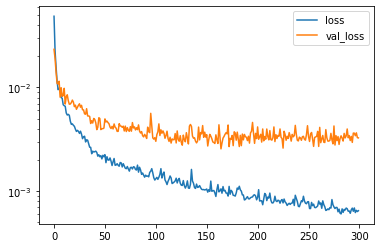

In [17]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(LSTM(units=100, return_sequences=True, 
               input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.1))

# Last layer doesn't return sequences (middle layers should return sequences)
model.add(LSTM(units=100))
model.add(Dropout(rate=0.1))

# Dense layer to return prediction
model.add(Dense(2))

# Compile model; adam optimizer, mse loss
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

result = model.fit(Xtrain, ytrain, verbose=1, validation_split=0.2,
                   callbacks = [TqdmCallback(verbose=1)],#es
                   batch_size=100,
                   epochs=300)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('lstm_control.h5')

### Preliminary model performance assessment

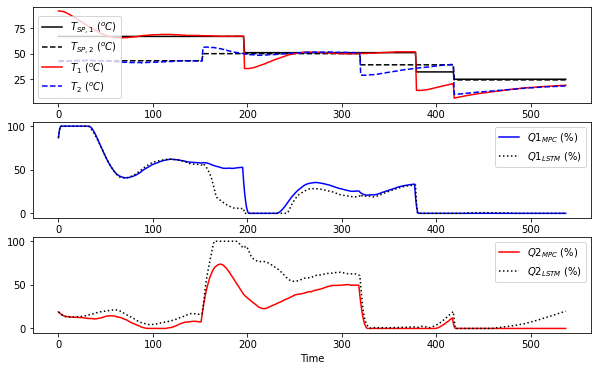

In [18]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)
yp = np.clip(yp,0.0,100.0)

# Derive Tsp (sp) and T1 (pv) from X data
sp1 = Xtest_us[:,0]
pv1 = Xtest_us[:,0] + Xtest_us[:,1]
sp2 = Xtest_us[:,2]
pv2 = Xtest_us[:,2] + Xtest_us[:,3]

# Plot SP, MPC response, and LSTM response
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(sp1,'k-',label='$T_{SP,1}$ $(^oC)$')
plt.plot(sp2,'k--',label='$T_{SP,2}$ $(^oC)$')
plt.plot(pv1,'r-',label='$T_1$ $(^oC)$')
plt.plot(pv2,'b--',label='$T_2$ $(^oC)$')
plt.legend()
plt.subplot(3,1,2)
plt.plot(ytest_us[:,0],'b-',label='$Q1_{MPC}$ (%)')
plt.plot(yp[:,0],'k:',label='$Q1_{LSTM}$ (%)')
plt.legend()
plt.subplot(3,1,3)
plt.plot(ytest_us[:,1],'r-',label='$Q2_{MPC}$ (%)')
plt.plot(yp[:,1],'k:',label='$Q2_{LSTM}$ (%)')
plt.legend()
plt.xlabel('Time')
plt.show()

### Generate SP data for test

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
TCLab disconnected successfully.


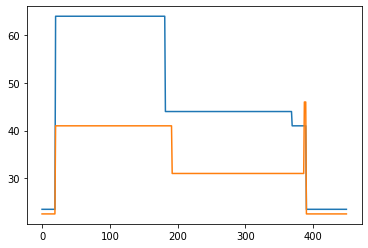

In [25]:
# Run time in minutes
run_time = 15.0

# Number of cycles
loops = int(30.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
T2 = np.zeros(loops)
Q1mpc = np.zeros(loops) # Heater values for MPC controller
Q2mpc = np.zeros(loops)
Q1lstm = np.zeros(loops) # Heater values for LSTM controller
Q2lstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.linspace(0,2*(loops-1),loops) # Time

# Temperature set point (degC)
with mlab() as lab:
    Tsp1 = np.ones(loops) * lab.T1
    Tsp2 = np.ones(loops) * lab.T2

# vary temperature setpoint
end = window + 5 # leave 1st window + 10 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 5 to 7 min
    end += random.randint(150,210) 
    Tsp1[start:end] = random.randint(30,70)
end = window + 5 # leave 1st window + 10 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 5 to 7 min
    end += random.randint(150,210) 
    Tsp2[start:end] = random.randint(30,50)
    
# leave last 120 seconds as room temp
Tsp1[-60:] = Tsp1[0]
Tsp2[-60:] = Tsp2[0]
plt.plot(Tsp1)
plt.plot(Tsp2)
plt.show()

### Part A: Run the controller with the MPC, but also output the LSTM for comparison

In [27]:
# LSTM Controller
def lstm(T1_m,Tsp1_m,T2_m,Tsp2_m):
    # Calculate error (necessary feature for LSTM input)
    err1 = Tsp1_m - T1_m
    err2 = Tsp2_m - T2_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp1_m,err1,Tsp2_m,err2)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Qc_s = model.predict(Xs)
    Qc = s_y.inverse_transform(Qc_s)[0]
    
    # Ensure Qc is between 0 and 100
    Qc = np.clip(Qc,0.0,100.0)
    return Qc

In [28]:
# Run test
with mlab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    i = 0
    for t in tclab.clock(tm[-1]+1, 2):
               
        # Read temperatures in Celcius 
        T1[i] = lab.T1; T2[i] = lab.T2

        # Calculate MPC output every 2 sec
        try:
            [Q1mpc[i],Q2mpc[i]] = mpc(m,T1[i],Tsp1[i],T2[i],Tsp2[i])
        except:
            Q1mpc[i]=0; Q2mpc[i]=0
        # Write heater output (0-100)
        lab.Q1(Q1mpc[i])
        lab.Q2(Q2mpc[i])
         
        if i%p1==0:            
            print('  Time_____Q1___Tsp1_____T1')
        if i%p2==0:
            print(('{:6.1f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Q1mpc[i],Tsp1[i],T1[i]))
        
        # Run LSTM model to get Q values for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp1_m = Tsp1[i-window:i]
            T2_m = T2[i-window:i]
            Tsp2_m = Tsp2[i-window:i]
            # Predict and store LSTM value for comparison
            Q1lstm[i],Q2lstm[i] = lstm(T1_m,Tsp1_m,T2_m,Tsp2_m)
        i+=1

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Temperature 1: 23.48 °C
Temperature 2: 22.51 °C
  Time_____Q1___Tsp1_____T1
   0.0   5.86  23.48  23.48
   2.0   6.01  23.48  23.48
   4.0   6.13  23.48  23.48
   6.0   6.23  23.48  23.48
   8.0   6.31  23.48  23.48
  10.0   6.34  23.48  23.51
  12.0   6.26  23.48  23.61
  14.0   6.09  23.48  23.70
  16.0   5.84  23.48  23.80
  18.0   5.62  23.48  23.80
  Time_____Q1___Tsp1_____T1
  20.0   5.45  23.48  23.80
  22.0   5.29  23.48  23.80
  24.0   5.16  23.48  23.80
  26.0   5.01  23.48  23.83
  28.0   4.89  23.48  23.83
  30.0   4.65  23.48  23.96
  32.0   4.28  23.48  24.12
  34.0   3.97  23.48  24.12
  36.0   3.71  23.48  24.12
  38.0   3.49  23.48  24.12
  Time_____Q1___Tsp1_____T1
  40.0  40.08  64.00  24.12
  42.0  67.20  64.00  24.15
  44.0  85.82  64.00  24.19
  46.0  96.56  64.00  24.44
  48.0 100.00  64.00  24.44
  50.0 100.00  64.00  24.77
  52.0 100.

[]

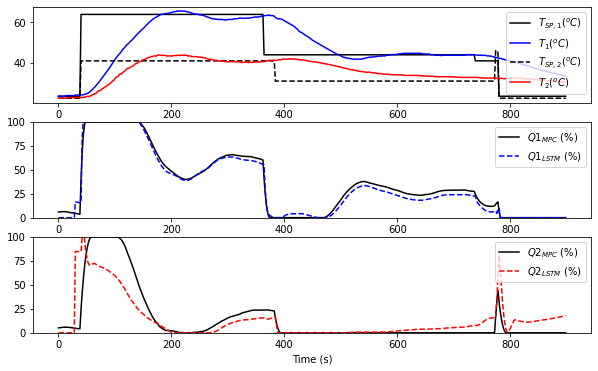

In [29]:
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(tm[:i],Tsp1[:i],'k-',label='$T_{SP,1} (^oC)$')
plt.plot(tm[:i],T1[:i],'b-',label='$T_1 (^oC)$')
plt.plot(tm[:i],Tsp2[:i],'k--',label='$T_{SP,2} (^oC)$')
plt.plot(tm[:i],T2[:i],'r-',label='$T_2 (^oC)$')
plt.legend(loc=1)
plt.subplot(3,1,2)
plt.plot(tm[:i],Q1mpc[:i],'k-',label='$Q1_{MPC}$ (%)')
plt.plot(tm[:i],Q1lstm[:i],'b--',label='$Q1_{LSTM}$ (%)')
plt.legend(loc=1)
plt.ylim([0,100])
plt.subplot(3,1,3)
plt.plot(tm[:i],Q2mpc[:i],'k-',label='$Q2_{MPC}$ (%)')
plt.plot(tm[:i],Q2lstm[:i],'r--',label='$Q2_{LSTM}$ (%)')
plt.legend(loc=1)
plt.ylim([0,100])
plt.xlabel('Time (s)')
plt.savefig('Compare_LSTM_MPC.png',dpi=300)
plt.plot()

### Part B: Run the controller with just the LSTM

In [30]:
# Run test
with mlab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    i = 0
    for t in tclab.clock(tm[-1]+1, 2):
        # Read temperatures in Celcius 
        T1[i] = lab.T1; T2[i] = lab.T2

        # Run LSTM model to get Q values for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp1_m = Tsp1[i-window:i]
            T2_m = T2[i-window:i]
            Tsp2_m = Tsp2[i-window:i]
            # Predict and store LSTM value for comparison
            Q1lstm[i],Q2lstm[i] = lstm(T1_m,Tsp1_m,T2_m,Tsp2_m)
            
        if i%p1==0:            
            print('  Time_____Q1___Tsp1_____T1_____Q2___Tsp2_____T2')
        if i%p2==0:
            print(('{:6.1f} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Q1lstm[i],Tsp1[i],T1[i],Q2lstm[i],Tsp2[i],T2[i]))

        # Write heater output (0-100)
        lab.Q1(Q1lstm[i])
        lab.Q2(Q2lstm[i])
        i+=1

TCLab version 0.4.9
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Temperature 1: 25.12 °C
Temperature 2: 24.77 °C
  Time_____Q1___Tsp1_____T1_____Q2___Tsp2_____T2
   0.0   0.00  23.48  25.12   0.00  22.51  24.77
   2.0   0.00  23.48  25.15   0.00  22.51  24.77
   4.0   0.00  23.48  25.15   0.00  22.51  24.77
   6.0   0.00  23.48  25.12   0.00  22.51  24.67
   8.0   0.00  23.48  25.09   0.00  22.51  24.64
  10.0   0.00  23.48  25.09   0.00  22.51  24.51
  12.0   0.00  23.48  25.09   0.00  22.51  24.44
  14.0   0.00  23.48  25.09   0.00  22.51  24.44
  16.0   0.00  23.48  25.09   0.00  22.51  24.44
  18.0   0.00  23.48  25.09   0.00  22.51  24.44
  Time_____Q1___Tsp1_____T1_____Q2___Tsp2_____T2
  20.0   0.00  23.48  25.09   0.00  22.51  24.44
  22.0   0.00  23.48  25.09   0.00  22.51  24.44
  24.0   0.00  23.48  25.09   0.00  22.51  24.44
  26.0   0.00  23.48  25.09   0.00  22.51  24.44
  28.0   0.00  23.48  25.09   0.00  22.

[]

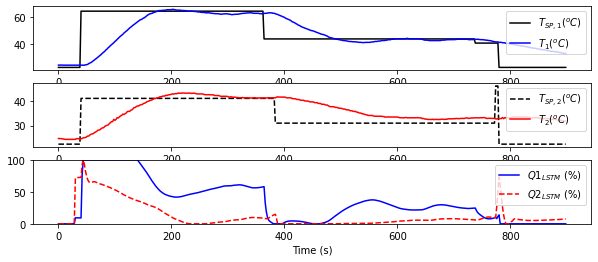

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(3,1,1)
plt.plot(tm[:i],Tsp1[:i],'k-',label='$T_{SP,1} (^oC)$')
plt.plot(tm[:i],T1[:i],'b-',label='$T_1 (^oC)$')
plt.legend(loc=1)
plt.subplot(3,1,2)
plt.plot(tm[:i],Tsp2[:i],'k--',label='$T_{SP,2} (^oC)$')
plt.plot(tm[:i],T2[:i],'r-',label='$T_2 (^oC)$')
plt.legend(loc=1)
plt.subplot(3,1,3)
plt.plot(tm[:i],Q1lstm[:i],'b-',label='$Q1_{LSTM}$ (%)')
plt.plot(tm[:i],Q2lstm[:i],'r--',label='$Q2_{LSTM}$ (%)')
plt.legend(loc=1)
plt.ylim([0,100])
plt.xlabel('Time (s)')
plt.savefig('LSTM_Control.png',dpi=300)
plt.plot()

So this does okay. I'm not actually that super impressed with it's performance. I bet that with more data it would do better. But the control performance isn't really very bad at the end of the day. So that's kinda cool. 

### Part C

Use the LSTM controller to control the [TCLab microcontroller](https://apmonitor.com/heat.htm) or [Emulated TCLab](https://tclab.readthedocs.io/en/latest/notebooks/04_Emulation_of_TCLab_for_Offline_Use.html) from a separate program. Demonstrate that you can [package and deploy the LSTM model](https://apmonitor.com/pds/index.php/Main/DeployMachineLearning) so that it could be used on a different computer than the training computer. The application does not necessarily need to run on a separate computer, but show that it is a separate program and independent of this training notebook.

<img align=left width=150px src='https://apmonitor.com/pds/uploads/Main/deploy_machine_learning.png'>

<img align=left width=400px src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

In [ ]:
import pickle
# export model name and scaling
z = ['lstm_control.h5',s_x,s_y,window]
pickle.dump(z,open('lstm_control.pkl','wb'))